# Collaboration and Competition

---

In this notebook, you will learn how to use the Unity ML-Agents environment for the third project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893) program.

### 1. Start the Environment

We begin by importing the necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
#!pip -q install ./python

In [2]:
from unityagents import UnityEnvironment
import random
import torch
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
from src.utils import *
from src.agentDDPG import Agent

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Tennis.app"`
- **Windows** (x86): `"path/to/Tennis_Windows_x86/Tennis.exe"`
- **Windows** (x86_64): `"path/to/Tennis_Windows_x86_64/Tennis.exe"`
- **Linux** (x86): `"path/to/Tennis_Linux/Tennis.x86"`
- **Linux** (x86_64): `"path/to/Tennis_Linux/Tennis.x86_64"`
- **Linux** (x86, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86"`
- **Linux** (x86_64, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86_64"`

For instance, if you are using a Mac, then you downloaded `Tennis.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Tennis.app")
```

In [3]:
env = UnityEnvironment(file_name="env/Tennis.exe")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [4]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

In this environment, two agents control rackets to bounce a ball over a net. If an agent hits the ball over the net, it receives a reward of +0.1.  If an agent lets a ball hit the ground or hits the ball out of bounds, it receives a reward of -0.01.  Thus, the goal of each agent is to keep the ball in play.

The observation space consists of 8 variables corresponding to the position and velocity of the ball and racket. Two continuous actions are available, corresponding to movement toward (or away from) the net, and jumping. 

Run the code cell below to print some information about the environment.

In [5]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -6.65278625 -1.5
 -0.          0.          6.83172083  6.         -0.          0.        ]


# DDGP

In [6]:
agents = [Agent(state_size, action_size, num_agents = 1, random_seed=10) for i in range(num_agents)]

In [7]:
def ddpg():
    scores_deque = deque(maxlen=100)
    scores_deque_300 = deque(maxlen=300)
    
    
    agent_scores = []
    scores_window = []
    scores_moving_avg_100 = []
    scores_moving_avg_300 = []
    
    is_done = False
    
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name] # reset the environment
        states = np.reshape(env_info.vector_observations, (1,num_agents*state_size)) # flatten states  
        
        for agent in agents:
            agent.reset()
            
        scores = np.zeros(num_agents) 
        
        for t in range(max_t):
            actions = np.reshape([agent.act(states, add_noise=True) for agent in agents], (1, num_agents*action_size))
            env_info = env.step(actions)[brain_name]
            
            next_states = np.reshape(env_info.vector_observations, (1, num_agents*state_size)) 
            rewards = env_info.rewards                   
            dones = env_info.local_done 
 
            for i, agent in enumerate(agents):
                    agent.step(states, actions, rewards[i], next_states, dones, i,t)  
                    
            states = next_states
            scores += np.max(rewards)
            if np.any(dones):
                break 
        
        
        score = np.max(scores)
        
        scores_deque.append(score)
        scores_deque_300.append(score)
        scores_window.append(score)
        scores_moving_avg_100.append(np.mean(scores_deque))
        scores_moving_avg_300.append(np.mean(scores_deque_300))
        
        
        if i_episode % 50 == 0:
            print('\rEpisode {}\tAverage Score: {:.4f}\tMax Score: {:.4f}'.format(i_episode, np.mean(scores_deque), np.max(scores_deque), end=""))
            
            fig = plt.figure(figsize=(12, 10))
            ax = fig.add_subplot(111)
            plt.plot(scores_window, label='Scores')
            plt.plot(scores_moving_avg_100, label='Average Scores (Last 100 episodes)')
            plt.plot(scores_moving_avg_300, label='Average Scores (Last 300 episodes)')
            plt.ylabel('Score')
            plt.xlabel('Episode #')
            plt.legend(loc='upper left');
            plt.grid()
            fig.savefig('results/scores.png')
            plt.show()
                
        print('\rEpisode {}\tAverage Score: {:.4f}\tMax Score: {:.4f}'.format(i_episode, np.mean(scores_deque), np.max(scores_deque), end=""))
        
        if ((np.mean(scores_deque) >= TARGET_SCORE) & (not is_done)):
            is_done  = True 
            
            torch.save(agent.actor_local.state_dict(), 'models/checkpoint_actor_tennis_0.5.pth')
            torch.save(agent.critic_local.state_dict(), 'models/checkpoint_critic_tennis_0.5.pth')
            
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_deque)))
            
            # Save results
            np.savetxt('results/scores_window_0.5.txt', (scores_window), fmt='%05d')
            np.savetxt('results/scores_moving_avg_0.5.txt', (scores_moving_avg_100), fmt='%05d')
            
            fig = plt.figure(figsize=(12, 10))
            ax = fig.add_subplot(111)
            plt.plot(scores_window, label='Scores')
            plt.plot(scores_moving_avg_100, label='Average Scores (Last 100 episodes)')
            plt.plot(scores_moving_avg_300, label='Average Scores (Last 300 episodes)')
            plt.ylabel('Score')
            plt.xlabel('Episode #')
            plt.legend(loc='upper left');
            plt.grid()
            fig.savefig('results/scores_final_0.5.png')
            plt.show()
            
            
        if (np.mean(scores_deque) >= 2.0):
            torch.save(agent.actor_local.state_dict(), 'models/checkpoint_actor_tennis_2.0.pth')
            torch.save(agent.critic_local.state_dict(), 'models/checkpoint_critic_tennis_2.0.pth')
            # Save results
            np.savetxt('results/scores_window_0.5.txt', (scores_window), fmt='%05d')
            np.savetxt('results/scores_moving_avg_0.5.txt', (scores_moving_avg_100), fmt='%05d')

            print('\nEnvironment solved (and improved) in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_deque)))
            fig = plt.figure(figsize=(12, 10))
            ax = fig.add_subplot(111)
            plt.plot(scores_window, label='Scores')
            plt.plot(scores_moving_avg_100, label='Average Scores (Last 100 episodes)')
            plt.plot(scores_moving_avg_300, label='Average Scores (Last 300 episodes)')
            plt.ylabel('Score')
            plt.xlabel('Episode #')
            plt.legend(loc='upper left');
            plt.grid()
            fig.savefig('results/scores_final_2.0.png')
            plt.show()

            break
            
    return scores_window, scores_moving_avg_100

Episode 1	Average Score: 0.0000	Max Score: 0.0000
Episode 2	Average Score: 0.0000	Max Score: 0.0000
Episode 3	Average Score: 0.0000	Max Score: 0.0000
Episode 4	Average Score: 0.0000	Max Score: 0.0000
Episode 5	Average Score: 0.0000	Max Score: 0.0000
Episode 6	Average Score: 0.0167	Max Score: 0.1000
Episode 7	Average Score: 0.0143	Max Score: 0.1000
Episode 8	Average Score: 0.0125	Max Score: 0.1000
Episode 9	Average Score: 0.0111	Max Score: 0.1000
Episode 10	Average Score: 0.0100	Max Score: 0.1000
Episode 11	Average Score: 0.0091	Max Score: 0.1000
Episode 12	Average Score: 0.0083	Max Score: 0.1000
Episode 13	Average Score: 0.0077	Max Score: 0.1000
Episode 14	Average Score: 0.0071	Max Score: 0.1000
Episode 15	Average Score: 0.0067	Max Score: 0.1000
Episode 16	Average Score: 0.0063	Max Score: 0.1000
Episode 17	Average Score: 0.0059	Max Score: 0.1000
Episode 18	Average Score: 0.0056	Max Score: 0.1000
Episode 19	Average Score: 0.0053	Max Score: 0.1000
Episode 20	Average Score: 0.0050	Max Sco

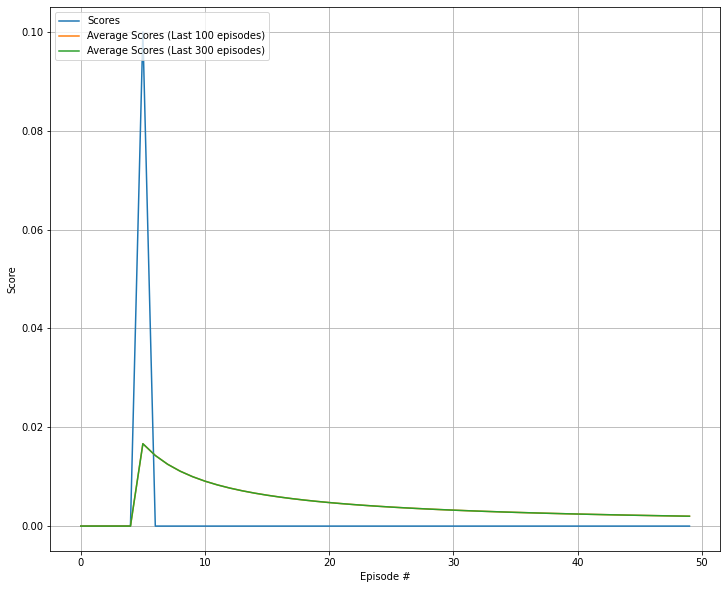

Episode 50	Average Score: 0.0020	Max Score: 0.1000
Episode 51	Average Score: 0.0020	Max Score: 0.1000
Episode 52	Average Score: 0.0019	Max Score: 0.1000
Episode 53	Average Score: 0.0038	Max Score: 0.1000
Episode 54	Average Score: 0.0037	Max Score: 0.1000
Episode 55	Average Score: 0.0036	Max Score: 0.1000
Episode 56	Average Score: 0.0036	Max Score: 0.1000
Episode 57	Average Score: 0.0035	Max Score: 0.1000
Episode 58	Average Score: 0.0034	Max Score: 0.1000
Episode 59	Average Score: 0.0034	Max Score: 0.1000
Episode 60	Average Score: 0.0033	Max Score: 0.1000
Episode 61	Average Score: 0.0033	Max Score: 0.1000
Episode 62	Average Score: 0.0032	Max Score: 0.1000
Episode 63	Average Score: 0.0032	Max Score: 0.1000
Episode 64	Average Score: 0.0031	Max Score: 0.1000
Episode 65	Average Score: 0.0031	Max Score: 0.1000
Episode 66	Average Score: 0.0030	Max Score: 0.1000
Episode 67	Average Score: 0.0030	Max Score: 0.1000
Episode 68	Average Score: 0.0029	Max Score: 0.1000
Episode 69	Average Score: 0.002

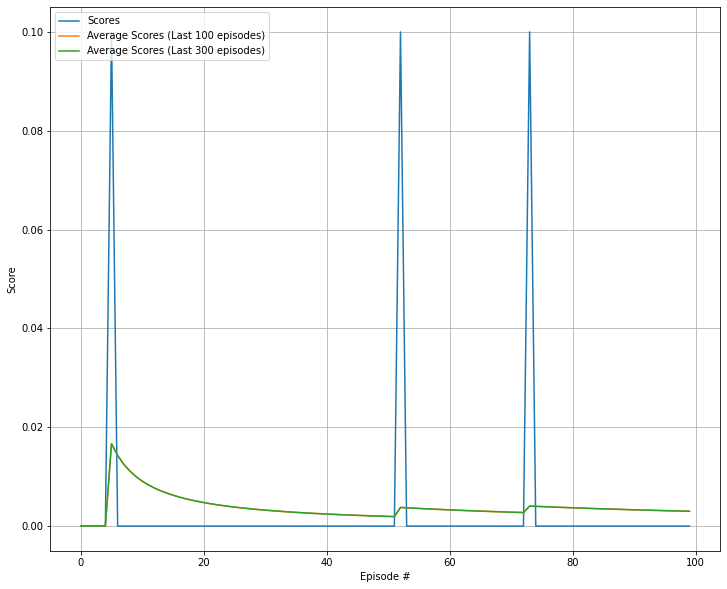

Episode 100	Average Score: 0.0030	Max Score: 0.1000
Episode 101	Average Score: 0.0030	Max Score: 0.1000
Episode 102	Average Score: 0.0030	Max Score: 0.1000
Episode 103	Average Score: 0.0030	Max Score: 0.1000
Episode 104	Average Score: 0.0030	Max Score: 0.1000
Episode 105	Average Score: 0.0030	Max Score: 0.1000
Episode 106	Average Score: 0.0020	Max Score: 0.1000
Episode 107	Average Score: 0.0020	Max Score: 0.1000
Episode 108	Average Score: 0.0020	Max Score: 0.1000
Episode 109	Average Score: 0.0020	Max Score: 0.1000
Episode 110	Average Score: 0.0020	Max Score: 0.1000
Episode 111	Average Score: 0.0030	Max Score: 0.1000
Episode 112	Average Score: 0.0030	Max Score: 0.1000
Episode 113	Average Score: 0.0040	Max Score: 0.1000
Episode 114	Average Score: 0.0040	Max Score: 0.1000
Episode 115	Average Score: 0.0050	Max Score: 0.1000
Episode 116	Average Score: 0.0050	Max Score: 0.1000
Episode 117	Average Score: 0.0050	Max Score: 0.1000
Episode 118	Average Score: 0.0050	Max Score: 0.1000
Episode 119	

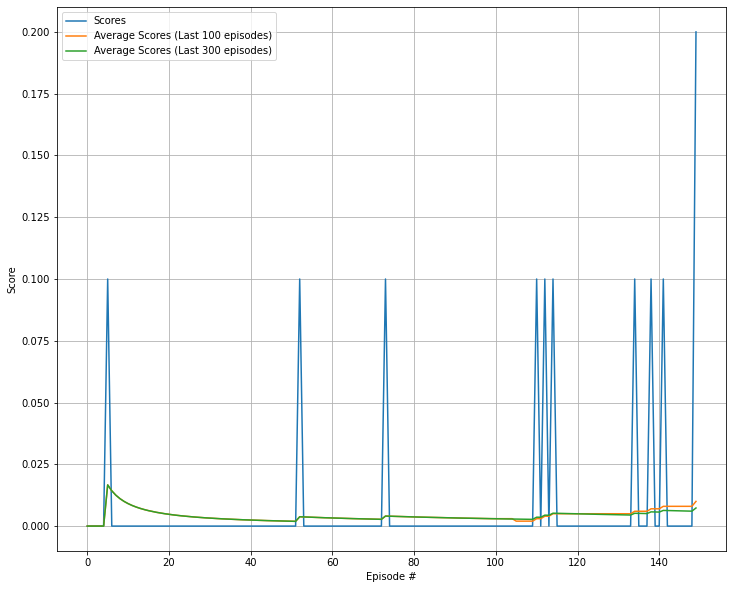

Episode 150	Average Score: 0.0100	Max Score: 0.2000
Episode 151	Average Score: 0.0100	Max Score: 0.2000
Episode 152	Average Score: 0.0100	Max Score: 0.2000
Episode 153	Average Score: 0.0110	Max Score: 0.2000
Episode 154	Average Score: 0.0110	Max Score: 0.2000
Episode 155	Average Score: 0.0110	Max Score: 0.2000
Episode 156	Average Score: 0.0110	Max Score: 0.2000
Episode 157	Average Score: 0.0110	Max Score: 0.2000
Episode 158	Average Score: 0.0110	Max Score: 0.2000
Episode 159	Average Score: 0.0110	Max Score: 0.2000
Episode 160	Average Score: 0.0120	Max Score: 0.2000
Episode 161	Average Score: 0.0120	Max Score: 0.2000
Episode 162	Average Score: 0.0130	Max Score: 0.2000
Episode 163	Average Score: 0.0140	Max Score: 0.2000
Episode 164	Average Score: 0.0140	Max Score: 0.2000
Episode 165	Average Score: 0.0150	Max Score: 0.2000
Episode 166	Average Score: 0.0150	Max Score: 0.2000
Episode 167	Average Score: 0.0150	Max Score: 0.2000
Episode 168	Average Score: 0.0150	Max Score: 0.2000
Episode 169	

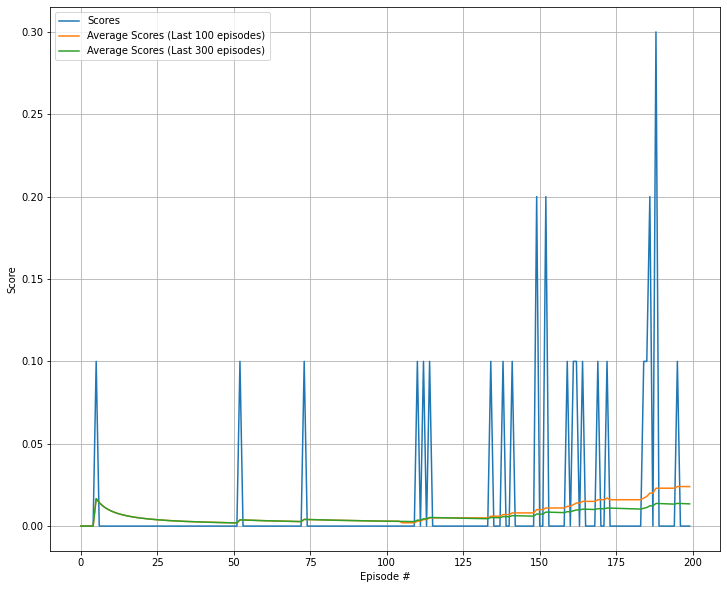

Episode 200	Average Score: 0.0240	Max Score: 0.3000
Episode 201	Average Score: 0.0260	Max Score: 0.3000
Episode 202	Average Score: 0.0260	Max Score: 0.3000
Episode 203	Average Score: 0.0270	Max Score: 0.3000
Episode 204	Average Score: 0.0280	Max Score: 0.3000
Episode 205	Average Score: 0.0280	Max Score: 0.3000
Episode 206	Average Score: 0.0280	Max Score: 0.3000
Episode 207	Average Score: 0.0280	Max Score: 0.3000
Episode 208	Average Score: 0.0280	Max Score: 0.3000
Episode 209	Average Score: 0.0280	Max Score: 0.3000
Episode 210	Average Score: 0.0290	Max Score: 0.3000
Episode 211	Average Score: 0.0290	Max Score: 0.3000
Episode 212	Average Score: 0.0290	Max Score: 0.3000
Episode 213	Average Score: 0.0290	Max Score: 0.3000
Episode 214	Average Score: 0.0290	Max Score: 0.3000
Episode 215	Average Score: 0.0300	Max Score: 0.3000
Episode 216	Average Score: 0.0300	Max Score: 0.3000
Episode 217	Average Score: 0.0310	Max Score: 0.3000
Episode 218	Average Score: 0.0310	Max Score: 0.3000
Episode 219	

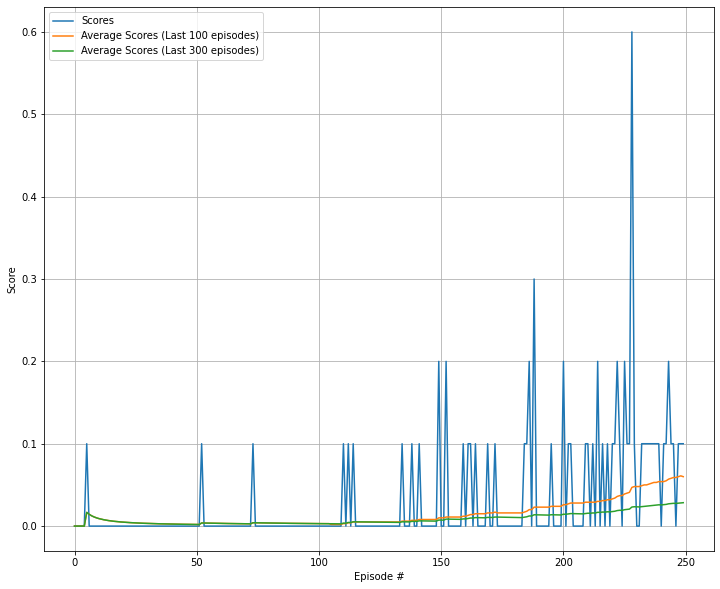

Episode 250	Average Score: 0.0600	Max Score: 0.6000
Episode 251	Average Score: 0.0610	Max Score: 0.6000
Episode 252	Average Score: 0.0620	Max Score: 0.6000
Episode 253	Average Score: 0.0610	Max Score: 0.6000
Episode 254	Average Score: 0.0610	Max Score: 0.6000
Episode 255	Average Score: 0.0610	Max Score: 0.6000
Episode 256	Average Score: 0.0610	Max Score: 0.6000
Episode 257	Average Score: 0.0620	Max Score: 0.6000
Episode 258	Average Score: 0.0630	Max Score: 0.6000
Episode 259	Average Score: 0.0640	Max Score: 0.6000
Episode 260	Average Score: 0.0640	Max Score: 0.6000
Episode 261	Average Score: 0.0640	Max Score: 0.6000
Episode 262	Average Score: 0.0640	Max Score: 0.6000
Episode 263	Average Score: 0.0640	Max Score: 0.6000
Episode 264	Average Score: 0.0640	Max Score: 0.6000
Episode 265	Average Score: 0.0630	Max Score: 0.6000
Episode 266	Average Score: 0.0630	Max Score: 0.6000
Episode 267	Average Score: 0.0640	Max Score: 0.6000
Episode 268	Average Score: 0.0650	Max Score: 0.6000
Episode 269	

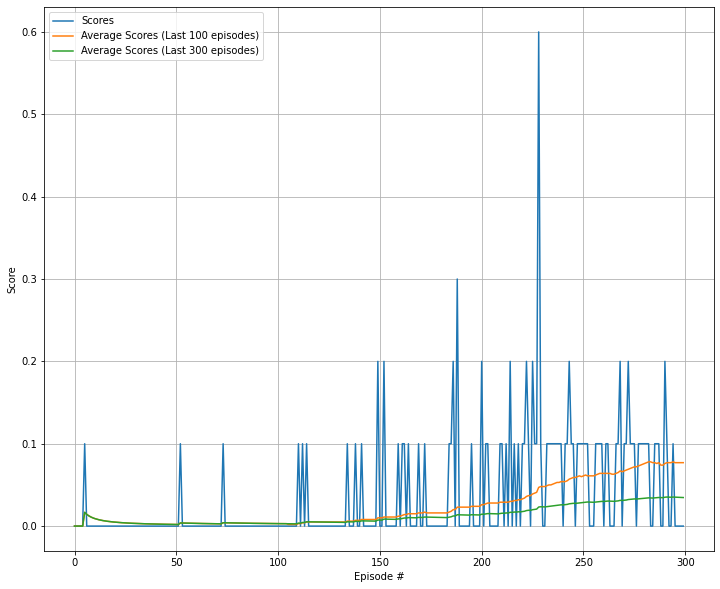

Episode 300	Average Score: 0.0770	Max Score: 0.6000
Episode 301	Average Score: 0.0760	Max Score: 0.6000
Episode 302	Average Score: 0.0770	Max Score: 0.6000
Episode 303	Average Score: 0.0770	Max Score: 0.6000
Episode 304	Average Score: 0.0770	Max Score: 0.6000
Episode 305	Average Score: 0.0770	Max Score: 0.6000
Episode 306	Average Score: 0.0770	Max Score: 0.6000
Episode 307	Average Score: 0.0770	Max Score: 0.6000
Episode 308	Average Score: 0.0770	Max Score: 0.6000
Episode 309	Average Score: 0.0770	Max Score: 0.6000
Episode 310	Average Score: 0.0760	Max Score: 0.6000
Episode 311	Average Score: 0.0770	Max Score: 0.6000
Episode 312	Average Score: 0.0770	Max Score: 0.6000
Episode 313	Average Score: 0.0760	Max Score: 0.6000
Episode 314	Average Score: 0.0760	Max Score: 0.6000
Episode 315	Average Score: 0.0740	Max Score: 0.6000
Episode 316	Average Score: 0.0760	Max Score: 0.6000
Episode 317	Average Score: 0.0750	Max Score: 0.6000
Episode 318	Average Score: 0.0750	Max Score: 0.6000
Episode 319	

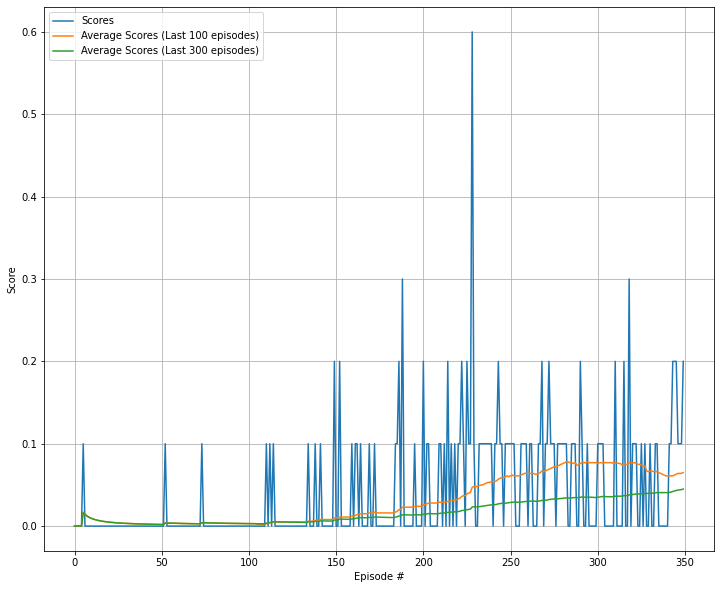

Episode 350	Average Score: 0.0650	Max Score: 0.3000
Episode 351	Average Score: 0.0650	Max Score: 0.3000
Episode 352	Average Score: 0.0660	Max Score: 0.3000
Episode 353	Average Score: 0.0660	Max Score: 0.3000
Episode 354	Average Score: 0.0670	Max Score: 0.3000
Episode 355	Average Score: 0.0680	Max Score: 0.3000
Episode 356	Average Score: 0.0690	Max Score: 0.3000
Episode 357	Average Score: 0.0690	Max Score: 0.3000
Episode 358	Average Score: 0.0680	Max Score: 0.3000
Episode 359	Average Score: 0.0680	Max Score: 0.3000
Episode 360	Average Score: 0.0680	Max Score: 0.3000
Episode 361	Average Score: 0.0690	Max Score: 0.3000
Episode 362	Average Score: 0.0690	Max Score: 0.3000
Episode 363	Average Score: 0.0710	Max Score: 0.3000
Episode 364	Average Score: 0.0710	Max Score: 0.3000
Episode 365	Average Score: 0.0720	Max Score: 0.3000
Episode 366	Average Score: 0.0740	Max Score: 0.3000
Episode 367	Average Score: 0.0740	Max Score: 0.3000
Episode 368	Average Score: 0.0780	Max Score: 0.5000
Episode 369	

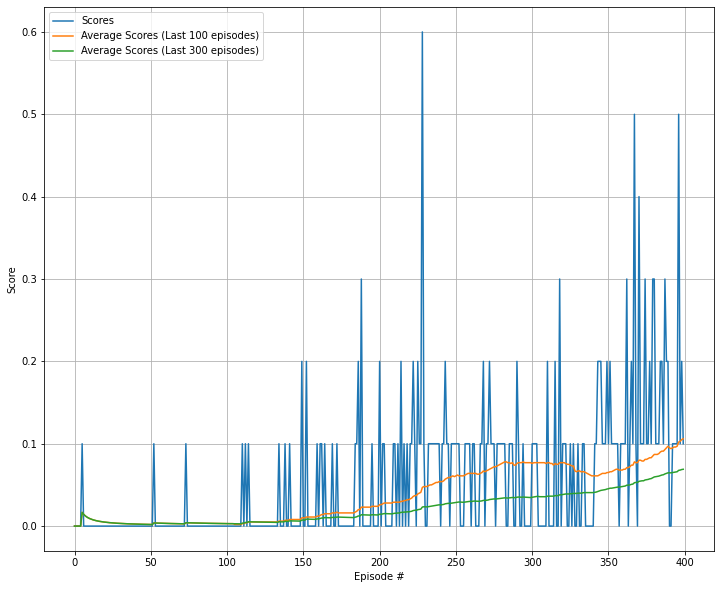

Episode 400	Average Score: 0.1060	Max Score: 0.5000
Episode 401	Average Score: 0.1060	Max Score: 0.5000
Episode 402	Average Score: 0.1060	Max Score: 0.5000
Episode 403	Average Score: 0.1060	Max Score: 0.5000
Episode 404	Average Score: 0.1060	Max Score: 0.5000
Episode 405	Average Score: 0.1100	Max Score: 0.5000
Episode 406	Average Score: 0.1130	Max Score: 0.5000
Episode 407	Average Score: 0.1160	Max Score: 0.5000
Episode 408	Average Score: 0.1180	Max Score: 0.5000
Episode 409	Average Score: 0.1190	Max Score: 0.5000
Episode 410	Average Score: 0.1220	Max Score: 0.5000
Episode 411	Average Score: 0.1330	Max Score: 1.3000
Episode 412	Average Score: 0.1340	Max Score: 1.3000
Episode 413	Average Score: 0.1360	Max Score: 1.3000
Episode 414	Average Score: 0.1370	Max Score: 1.3000
Episode 415	Average Score: 0.1400	Max Score: 1.3000
Episode 416	Average Score: 0.1400	Max Score: 1.3000
Episode 417	Average Score: 0.1410	Max Score: 1.3000
Episode 418	Average Score: 0.1420	Max Score: 1.3000
Episode 419	

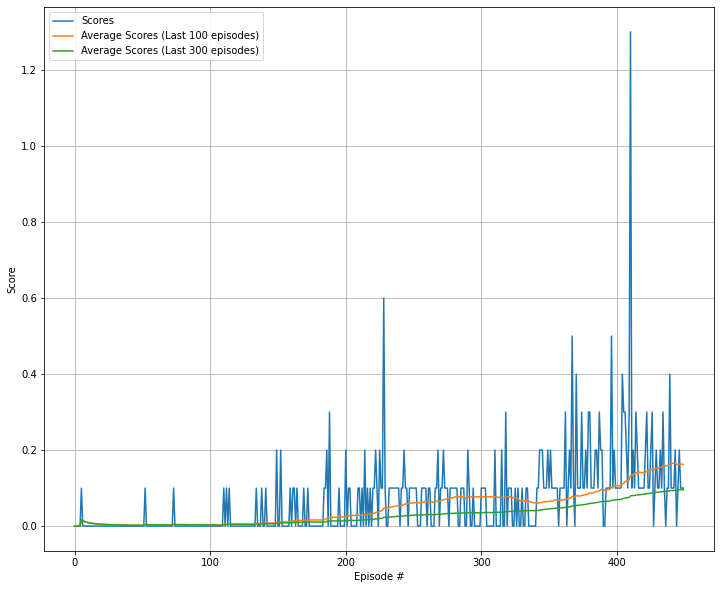

Episode 450	Average Score: 0.1620	Max Score: 1.3000
Episode 451	Average Score: 0.1610	Max Score: 1.3000
Episode 452	Average Score: 0.1600	Max Score: 1.3000
Episode 453	Average Score: 0.1600	Max Score: 1.3000
Episode 454	Average Score: 0.1590	Max Score: 1.3000
Episode 455	Average Score: 0.1600	Max Score: 1.3000
Episode 456	Average Score: 0.1590	Max Score: 1.3000
Episode 457	Average Score: 0.1590	Max Score: 1.3000
Episode 458	Average Score: 0.1600	Max Score: 1.3000
Episode 459	Average Score: 0.1600	Max Score: 1.3000
Episode 460	Average Score: 0.1600	Max Score: 1.3000
Episode 461	Average Score: 0.1610	Max Score: 1.3000
Episode 462	Average Score: 0.1620	Max Score: 1.3000
Episode 463	Average Score: 0.1590	Max Score: 1.3000
Episode 464	Average Score: 0.1600	Max Score: 1.3000
Episode 465	Average Score: 0.1590	Max Score: 1.3000
Episode 466	Average Score: 0.1610	Max Score: 1.3000
Episode 467	Average Score: 0.1600	Max Score: 1.3000
Episode 468	Average Score: 0.1560	Max Score: 1.3000
Episode 469	

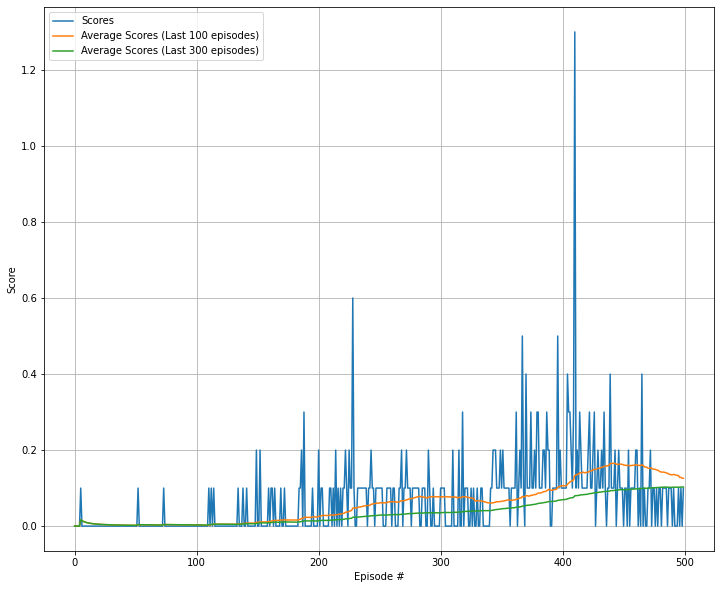

Episode 500	Average Score: 0.1260	Max Score: 1.3000
Episode 501	Average Score: 0.1260	Max Score: 1.3000
Episode 502	Average Score: 0.1250	Max Score: 1.3000
Episode 503	Average Score: 0.1250	Max Score: 1.3000
Episode 504	Average Score: 0.1250	Max Score: 1.3000
Episode 505	Average Score: 0.1210	Max Score: 1.3000
Episode 506	Average Score: 0.1190	Max Score: 1.3000
Episode 507	Average Score: 0.1160	Max Score: 1.3000
Episode 508	Average Score: 0.1150	Max Score: 1.3000
Episode 509	Average Score: 0.1150	Max Score: 1.3000
Episode 510	Average Score: 0.1120	Max Score: 1.3000
Episode 511	Average Score: 0.1000	Max Score: 0.4000
Episode 512	Average Score: 0.1000	Max Score: 0.4000
Episode 513	Average Score: 0.0980	Max Score: 0.4000
Episode 514	Average Score: 0.0980	Max Score: 0.4000
Episode 515	Average Score: 0.0950	Max Score: 0.4000
Episode 516	Average Score: 0.0930	Max Score: 0.4000
Episode 517	Average Score: 0.0930	Max Score: 0.4000
Episode 518	Average Score: 0.0930	Max Score: 0.4000
Episode 519	

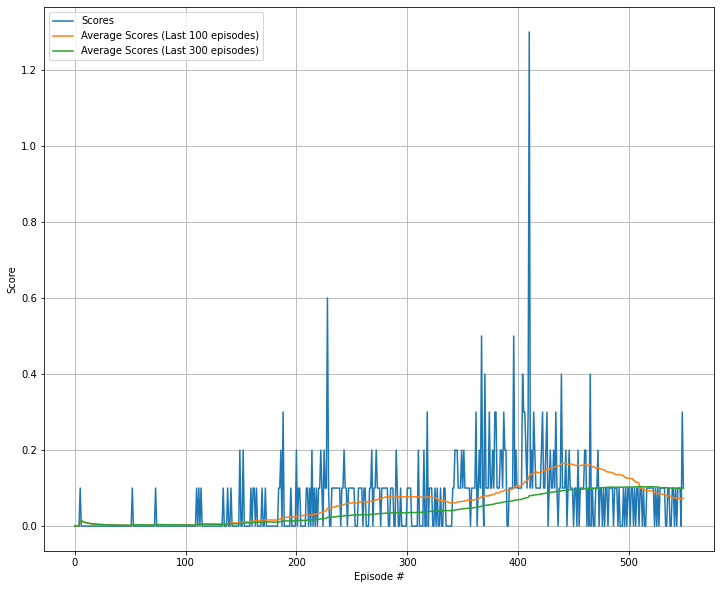

Episode 550	Average Score: 0.0730	Max Score: 0.4000
Episode 551	Average Score: 0.0740	Max Score: 0.4000
Episode 552	Average Score: 0.0740	Max Score: 0.4000
Episode 553	Average Score: 0.0730	Max Score: 0.4000
Episode 554	Average Score: 0.0740	Max Score: 0.4000
Episode 555	Average Score: 0.0730	Max Score: 0.4000
Episode 556	Average Score: 0.0740	Max Score: 0.4000
Episode 557	Average Score: 0.0740	Max Score: 0.4000
Episode 558	Average Score: 0.0730	Max Score: 0.4000
Episode 559	Average Score: 0.0730	Max Score: 0.4000
Episode 560	Average Score: 0.0730	Max Score: 0.4000
Episode 561	Average Score: 0.0710	Max Score: 0.4000
Episode 562	Average Score: 0.0700	Max Score: 0.4000
Episode 563	Average Score: 0.0710	Max Score: 0.4000
Episode 564	Average Score: 0.0710	Max Score: 0.4000
Episode 565	Average Score: 0.0710	Max Score: 0.4000
Episode 566	Average Score: 0.0680	Max Score: 0.3000
Episode 567	Average Score: 0.0680	Max Score: 0.3000
Episode 568	Average Score: 0.0670	Max Score: 0.3000
Episode 569	

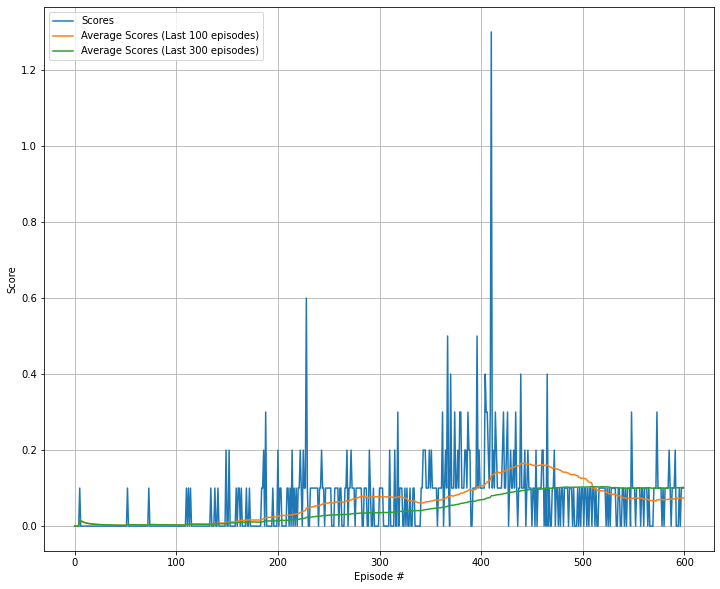

Episode 600	Average Score: 0.0740	Max Score: 0.3000
Episode 601	Average Score: 0.0740	Max Score: 0.3000
Episode 602	Average Score: 0.0750	Max Score: 0.3000
Episode 603	Average Score: 0.0740	Max Score: 0.3000
Episode 604	Average Score: 0.0730	Max Score: 0.3000
Episode 605	Average Score: 0.0740	Max Score: 0.3000
Episode 606	Average Score: 0.0740	Max Score: 0.3000
Episode 607	Average Score: 0.0750	Max Score: 0.3000
Episode 608	Average Score: 0.0740	Max Score: 0.3000
Episode 609	Average Score: 0.0740	Max Score: 0.3000
Episode 610	Average Score: 0.0750	Max Score: 0.3000
Episode 611	Average Score: 0.0740	Max Score: 0.3000
Episode 612	Average Score: 0.0740	Max Score: 0.3000
Episode 613	Average Score: 0.0750	Max Score: 0.3000
Episode 614	Average Score: 0.0750	Max Score: 0.3000
Episode 615	Average Score: 0.0750	Max Score: 0.3000
Episode 616	Average Score: 0.0760	Max Score: 0.3000
Episode 617	Average Score: 0.0750	Max Score: 0.3000
Episode 618	Average Score: 0.0740	Max Score: 0.3000
Episode 619	

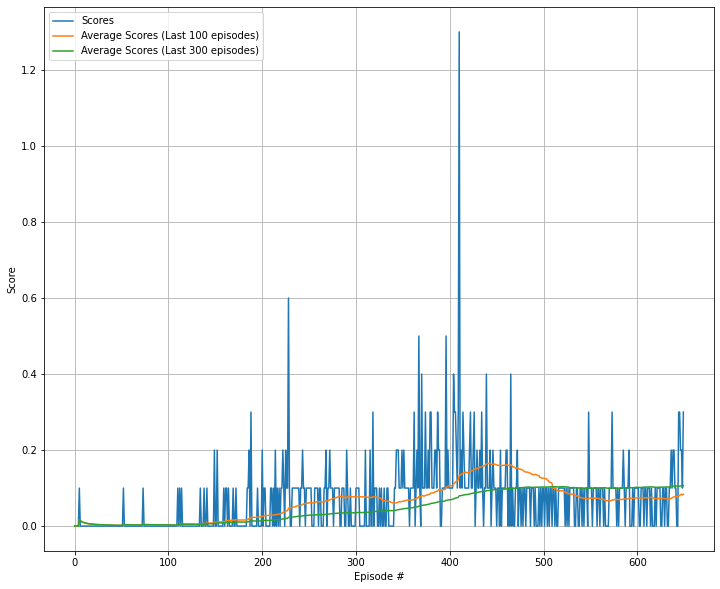

Episode 650	Average Score: 0.0840	Max Score: 0.3000
Episode 651	Average Score: 0.0840	Max Score: 0.3000
Episode 652	Average Score: 0.0840	Max Score: 0.3000
Episode 653	Average Score: 0.0850	Max Score: 0.3000
Episode 654	Average Score: 0.0860	Max Score: 0.3000
Episode 655	Average Score: 0.0870	Max Score: 0.3000
Episode 656	Average Score: 0.0880	Max Score: 0.3000
Episode 657	Average Score: 0.0900	Max Score: 0.3000
Episode 658	Average Score: 0.0920	Max Score: 0.3000
Episode 659	Average Score: 0.0920	Max Score: 0.3000
Episode 660	Average Score: 0.0920	Max Score: 0.3000
Episode 661	Average Score: 0.0940	Max Score: 0.3000
Episode 662	Average Score: 0.0950	Max Score: 0.3000
Episode 663	Average Score: 0.0960	Max Score: 0.3000
Episode 664	Average Score: 0.0960	Max Score: 0.3000
Episode 665	Average Score: 0.0970	Max Score: 0.3000
Episode 666	Average Score: 0.0980	Max Score: 0.3000
Episode 667	Average Score: 0.1000	Max Score: 0.3000
Episode 668	Average Score: 0.1010	Max Score: 0.3000
Episode 669	

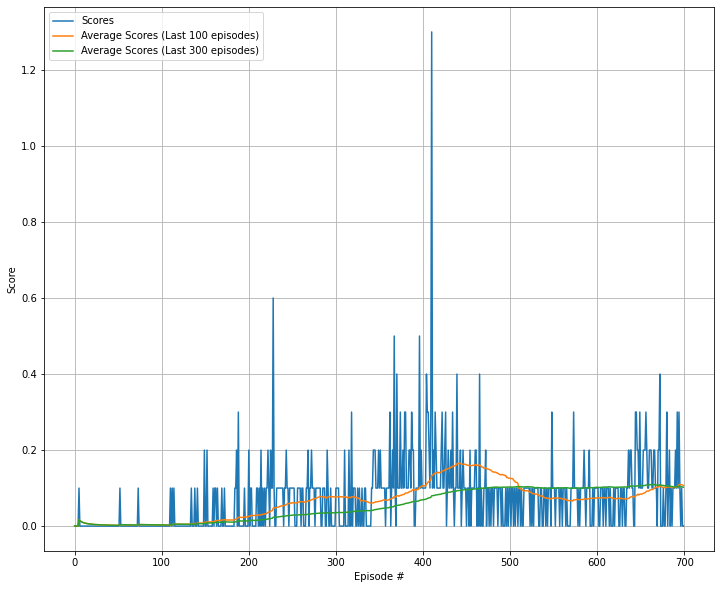

Episode 700	Average Score: 0.1070	Max Score: 0.4000
Episode 701	Average Score: 0.1070	Max Score: 0.4000
Episode 702	Average Score: 0.1070	Max Score: 0.4000
Episode 703	Average Score: 0.1080	Max Score: 0.4000
Episode 704	Average Score: 0.1090	Max Score: 0.4000
Episode 705	Average Score: 0.1080	Max Score: 0.4000
Episode 706	Average Score: 0.1080	Max Score: 0.4000
Episode 707	Average Score: 0.1090	Max Score: 0.4000
Episode 708	Average Score: 0.1090	Max Score: 0.4000
Episode 709	Average Score: 0.1100	Max Score: 0.4000
Episode 710	Average Score: 0.1100	Max Score: 0.4000
Episode 711	Average Score: 0.1110	Max Score: 0.4000
Episode 712	Average Score: 0.1110	Max Score: 0.4000
Episode 713	Average Score: 0.1110	Max Score: 0.4000
Episode 714	Average Score: 0.1130	Max Score: 0.4000
Episode 715	Average Score: 0.1130	Max Score: 0.4000
Episode 716	Average Score: 0.1130	Max Score: 0.4000
Episode 717	Average Score: 0.1140	Max Score: 0.4000
Episode 718	Average Score: 0.1170	Max Score: 0.4000
Episode 719	

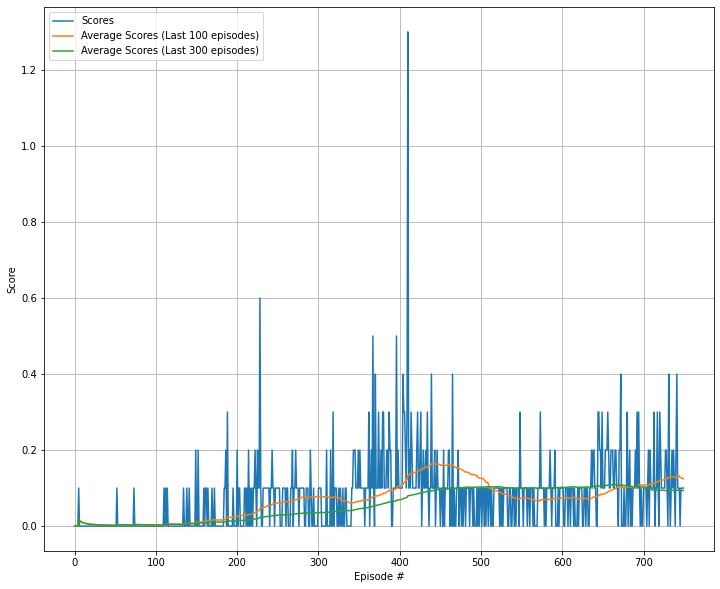

Episode 750	Average Score: 0.1240	Max Score: 0.4000
Episode 751	Average Score: 0.1240	Max Score: 0.4000
Episode 752	Average Score: 0.1240	Max Score: 0.4000
Episode 753	Average Score: 0.1240	Max Score: 0.4000
Episode 754	Average Score: 0.1230	Max Score: 0.4000
Episode 755	Average Score: 0.1220	Max Score: 0.4000
Episode 756	Average Score: 0.1210	Max Score: 0.4000
Episode 757	Average Score: 0.1190	Max Score: 0.4000
Episode 758	Average Score: 0.1180	Max Score: 0.4000
Episode 759	Average Score: 0.1190	Max Score: 0.4000
Episode 760	Average Score: 0.1190	Max Score: 0.4000
Episode 761	Average Score: 0.1180	Max Score: 0.4000
Episode 762	Average Score: 0.1170	Max Score: 0.4000
Episode 763	Average Score: 0.1150	Max Score: 0.4000
Episode 764	Average Score: 0.1140	Max Score: 0.4000
Episode 765	Average Score: 0.1140	Max Score: 0.4000
Episode 766	Average Score: 0.1140	Max Score: 0.4000
Episode 767	Average Score: 0.1120	Max Score: 0.4000
Episode 768	Average Score: 0.1130	Max Score: 0.4000
Episode 769	

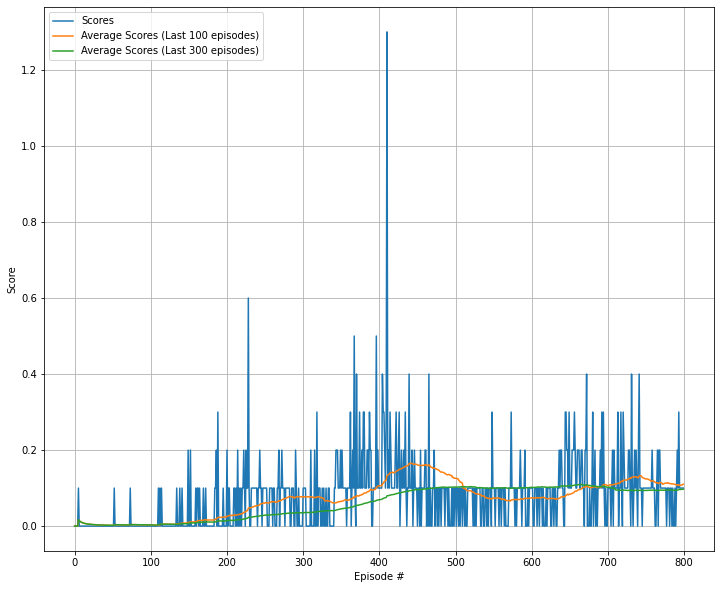

Episode 800	Average Score: 0.1100	Max Score: 0.4000
Episode 801	Average Score: 0.1100	Max Score: 0.4000
Episode 802	Average Score: 0.1090	Max Score: 0.4000
Episode 803	Average Score: 0.1090	Max Score: 0.4000
Episode 804	Average Score: 0.1100	Max Score: 0.4000
Episode 805	Average Score: 0.1100	Max Score: 0.4000
Episode 806	Average Score: 0.1110	Max Score: 0.4000
Episode 807	Average Score: 0.1100	Max Score: 0.4000
Episode 808	Average Score: 0.1110	Max Score: 0.4000
Episode 809	Average Score: 0.1100	Max Score: 0.4000
Episode 810	Average Score: 0.1090	Max Score: 0.4000
Episode 811	Average Score: 0.1090	Max Score: 0.4000
Episode 812	Average Score: 0.1100	Max Score: 0.4000
Episode 813	Average Score: 0.1090	Max Score: 0.4000
Episode 814	Average Score: 0.1080	Max Score: 0.4000
Episode 815	Average Score: 0.1090	Max Score: 0.4000
Episode 816	Average Score: 0.1090	Max Score: 0.4000
Episode 817	Average Score: 0.1080	Max Score: 0.4000
Episode 818	Average Score: 0.1050	Max Score: 0.4000
Episode 819	

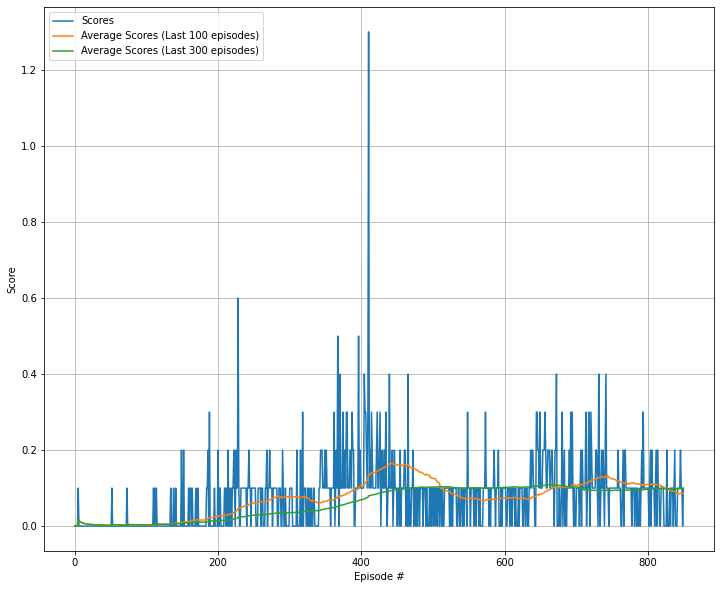

Episode 850	Average Score: 0.0860	Max Score: 0.3000
Episode 851	Average Score: 0.0850	Max Score: 0.3000
Episode 852	Average Score: 0.0860	Max Score: 0.3000
Episode 853	Average Score: 0.0870	Max Score: 0.3000
Episode 854	Average Score: 0.0870	Max Score: 0.3000
Episode 855	Average Score: 0.0860	Max Score: 0.3000
Episode 856	Average Score: 0.0850	Max Score: 0.3000
Episode 857	Average Score: 0.0860	Max Score: 0.3000
Episode 858	Average Score: 0.0850	Max Score: 0.3000
Episode 859	Average Score: 0.0840	Max Score: 0.3000
Episode 860	Average Score: 0.0840	Max Score: 0.3000
Episode 861	Average Score: 0.0850	Max Score: 0.3000
Episode 862	Average Score: 0.0850	Max Score: 0.3000
Episode 863	Average Score: 0.0860	Max Score: 0.3000
Episode 864	Average Score: 0.0860	Max Score: 0.3000
Episode 865	Average Score: 0.0850	Max Score: 0.3000
Episode 866	Average Score: 0.0830	Max Score: 0.3000
Episode 867	Average Score: 0.0840	Max Score: 0.3000
Episode 868	Average Score: 0.0830	Max Score: 0.3000
Episode 869	

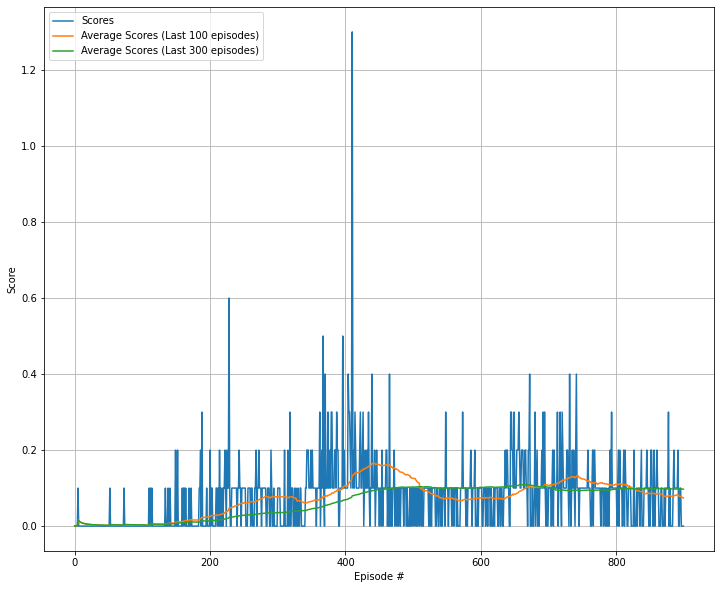

Episode 900	Average Score: 0.0740	Max Score: 0.3000
Episode 901	Average Score: 0.0740	Max Score: 0.3000
Episode 902	Average Score: 0.0740	Max Score: 0.3000
Episode 903	Average Score: 0.0740	Max Score: 0.3000
Episode 904	Average Score: 0.0730	Max Score: 0.3000
Episode 905	Average Score: 0.0730	Max Score: 0.3000
Episode 906	Average Score: 0.0720	Max Score: 0.3000
Episode 907	Average Score: 0.0720	Max Score: 0.3000
Episode 908	Average Score: 0.0720	Max Score: 0.3000
Episode 909	Average Score: 0.0720	Max Score: 0.3000
Episode 910	Average Score: 0.0720	Max Score: 0.3000
Episode 911	Average Score: 0.0720	Max Score: 0.3000
Episode 912	Average Score: 0.0700	Max Score: 0.3000
Episode 913	Average Score: 0.0710	Max Score: 0.3000
Episode 914	Average Score: 0.0690	Max Score: 0.3000
Episode 915	Average Score: 0.0680	Max Score: 0.3000
Episode 916	Average Score: 0.0680	Max Score: 0.3000
Episode 917	Average Score: 0.0680	Max Score: 0.3000
Episode 918	Average Score: 0.0690	Max Score: 0.3000
Episode 919	

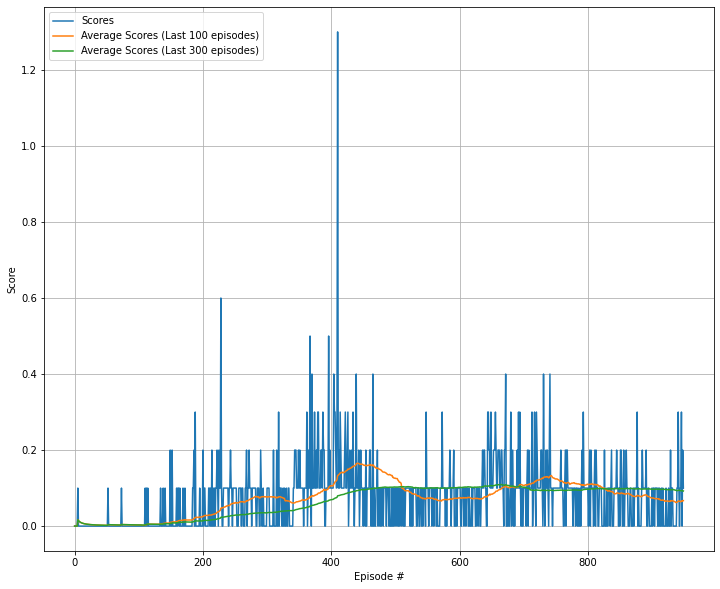

Episode 950	Average Score: 0.0670	Max Score: 0.3000
Episode 951	Average Score: 0.0690	Max Score: 0.3000
Episode 952	Average Score: 0.0700	Max Score: 0.3000
Episode 953	Average Score: 0.0680	Max Score: 0.3000
Episode 954	Average Score: 0.0670	Max Score: 0.3000
Episode 955	Average Score: 0.0680	Max Score: 0.3000
Episode 956	Average Score: 0.0690	Max Score: 0.3000
Episode 957	Average Score: 0.0680	Max Score: 0.3000
Episode 958	Average Score: 0.0680	Max Score: 0.3000
Episode 959	Average Score: 0.0670	Max Score: 0.3000
Episode 960	Average Score: 0.0660	Max Score: 0.3000
Episode 961	Average Score: 0.0640	Max Score: 0.3000
Episode 962	Average Score: 0.0639	Max Score: 0.3000
Episode 963	Average Score: 0.0659	Max Score: 0.3000
Episode 964	Average Score: 0.0669	Max Score: 0.3000
Episode 965	Average Score: 0.0679	Max Score: 0.3000
Episode 966	Average Score: 0.0679	Max Score: 0.3000
Episode 967	Average Score: 0.0669	Max Score: 0.3000
Episode 968	Average Score: 0.0659	Max Score: 0.3000
Episode 969	

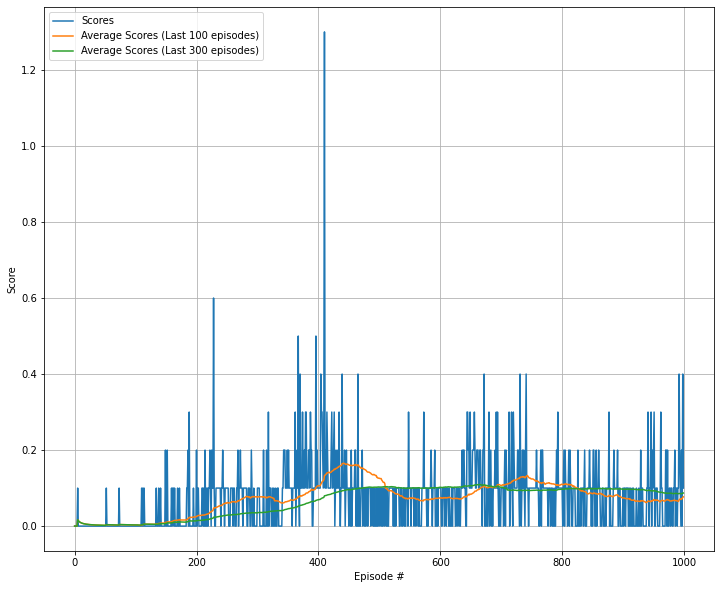

Episode 1000	Average Score: 0.0769	Max Score: 0.4000
Episode 1001	Average Score: 0.0769	Max Score: 0.4000
Episode 1002	Average Score: 0.0779	Max Score: 0.4000
Episode 1003	Average Score: 0.0779	Max Score: 0.4000
Episode 1004	Average Score: 0.0789	Max Score: 0.4000
Episode 1005	Average Score: 0.0809	Max Score: 0.4000
Episode 1006	Average Score: 0.0809	Max Score: 0.4000
Episode 1007	Average Score: 0.0809	Max Score: 0.4000
Episode 1008	Average Score: 0.0809	Max Score: 0.4000
Episode 1009	Average Score: 0.0809	Max Score: 0.4000
Episode 1010	Average Score: 0.0809	Max Score: 0.4000
Episode 1011	Average Score: 0.0809	Max Score: 0.4000
Episode 1012	Average Score: 0.0819	Max Score: 0.4000
Episode 1013	Average Score: 0.0829	Max Score: 0.4000
Episode 1014	Average Score: 0.0829	Max Score: 0.4000
Episode 1015	Average Score: 0.0839	Max Score: 0.4000
Episode 1016	Average Score: 0.0839	Max Score: 0.4000
Episode 1017	Average Score: 0.0859	Max Score: 0.4000
Episode 1018	Average Score: 0.0859	Max Score: 

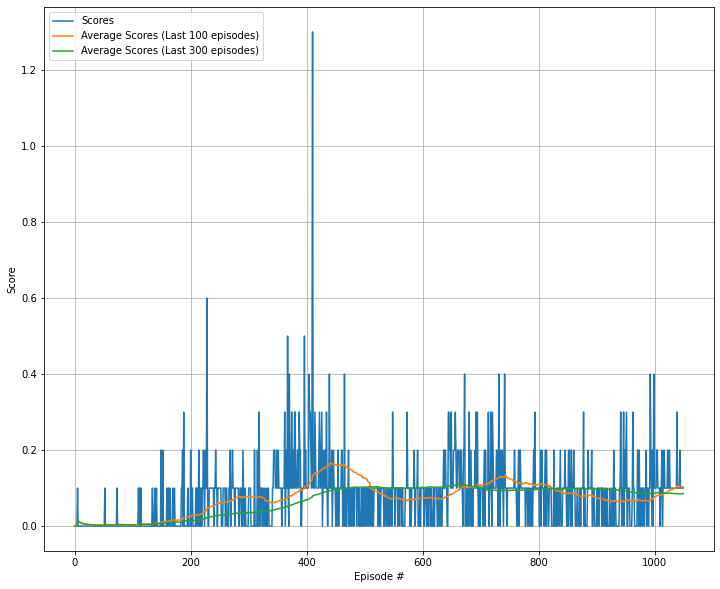

Episode 1050	Average Score: 0.1029	Max Score: 0.4000
Episode 1051	Average Score: 0.1049	Max Score: 0.4000
Episode 1052	Average Score: 0.1049	Max Score: 0.4000
Episode 1053	Average Score: 0.1069	Max Score: 0.4000
Episode 1054	Average Score: 0.1079	Max Score: 0.4000
Episode 1055	Average Score: 0.1089	Max Score: 0.4000
Episode 1056	Average Score: 0.1099	Max Score: 0.4000
Episode 1057	Average Score: 0.1099	Max Score: 0.4000
Episode 1058	Average Score: 0.1109	Max Score: 0.4000
Episode 1059	Average Score: 0.1129	Max Score: 0.4000
Episode 1060	Average Score: 0.1139	Max Score: 0.4000
Episode 1061	Average Score: 0.1159	Max Score: 0.4000
Episode 1062	Average Score: 0.1160	Max Score: 0.4000
Episode 1063	Average Score: 0.1150	Max Score: 0.4000
Episode 1064	Average Score: 0.1170	Max Score: 0.4000
Episode 1065	Average Score: 0.1190	Max Score: 0.4000
Episode 1066	Average Score: 0.1200	Max Score: 0.4000
Episode 1067	Average Score: 0.1220	Max Score: 0.4000
Episode 1068	Average Score: 0.1230	Max Score: 

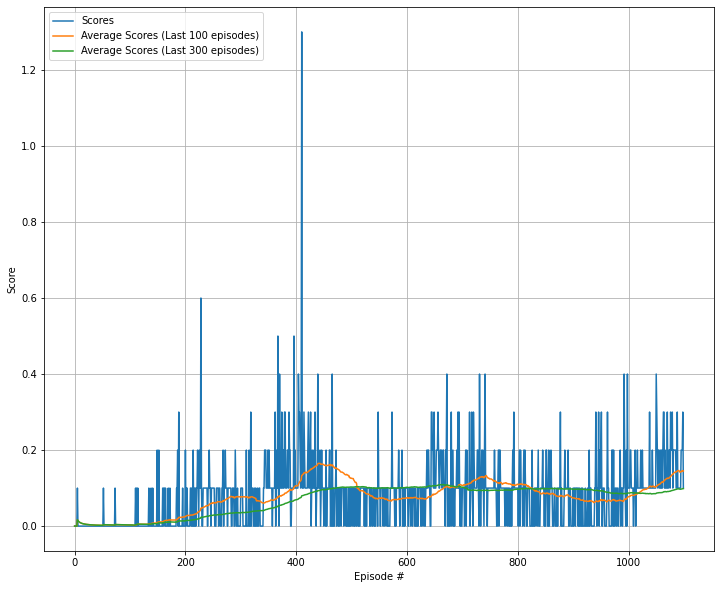

Episode 1100	Average Score: 0.1450	Max Score: 0.4000
Episode 1101	Average Score: 0.1480	Max Score: 0.4000
Episode 1102	Average Score: 0.1500	Max Score: 0.4000
Episode 1103	Average Score: 0.1520	Max Score: 0.4000
Episode 1104	Average Score: 0.1510	Max Score: 0.4000
Episode 1105	Average Score: 0.1500	Max Score: 0.4000
Episode 1106	Average Score: 0.1540	Max Score: 0.5000
Episode 1107	Average Score: 0.1540	Max Score: 0.5000
Episode 1108	Average Score: 0.1540	Max Score: 0.5000
Episode 1109	Average Score: 0.1560	Max Score: 0.5000
Episode 1110	Average Score: 0.1570	Max Score: 0.5000
Episode 1111	Average Score: 0.1570	Max Score: 0.5000
Episode 1112	Average Score: 0.1570	Max Score: 0.5000
Episode 1113	Average Score: 0.1560	Max Score: 0.5000
Episode 1114	Average Score: 0.1580	Max Score: 0.5000
Episode 1115	Average Score: 0.1590	Max Score: 0.5000
Episode 1116	Average Score: 0.1590	Max Score: 0.5000
Episode 1117	Average Score: 0.1580	Max Score: 0.5000
Episode 1118	Average Score: 0.1580	Max Score: 

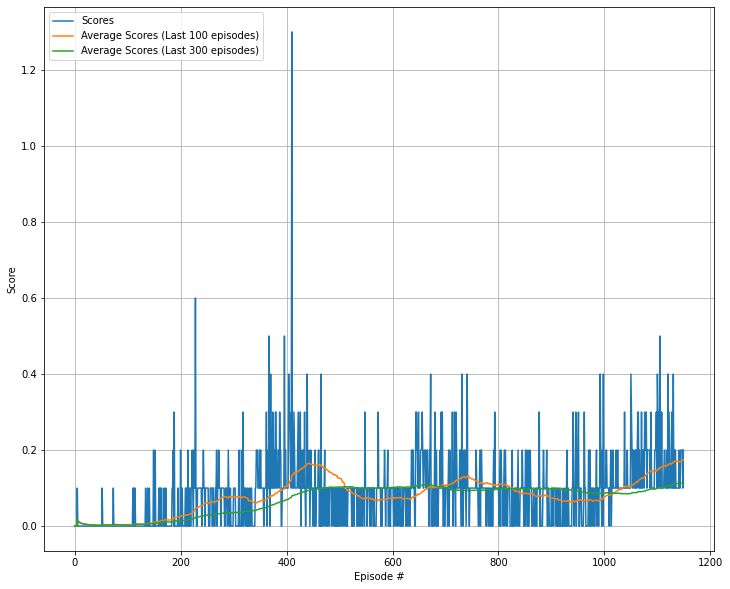

Episode 1150	Average Score: 0.1740	Max Score: 0.5000
Episode 1151	Average Score: 0.1710	Max Score: 0.5000
Episode 1152	Average Score: 0.1710	Max Score: 0.5000
Episode 1153	Average Score: 0.1720	Max Score: 0.5000
Episode 1154	Average Score: 0.1710	Max Score: 0.5000
Episode 1155	Average Score: 0.1700	Max Score: 0.5000
Episode 1156	Average Score: 0.1680	Max Score: 0.5000
Episode 1157	Average Score: 0.1680	Max Score: 0.5000
Episode 1158	Average Score: 0.1680	Max Score: 0.5000
Episode 1159	Average Score: 0.1680	Max Score: 0.5000
Episode 1160	Average Score: 0.1670	Max Score: 0.5000
Episode 1161	Average Score: 0.1670	Max Score: 0.5000
Episode 1162	Average Score: 0.1660	Max Score: 0.5000
Episode 1163	Average Score: 0.1640	Max Score: 0.5000
Episode 1164	Average Score: 0.1610	Max Score: 0.5000
Episode 1165	Average Score: 0.1580	Max Score: 0.5000
Episode 1166	Average Score: 0.1590	Max Score: 0.5000
Episode 1167	Average Score: 0.1570	Max Score: 0.5000
Episode 1168	Average Score: 0.1580	Max Score: 

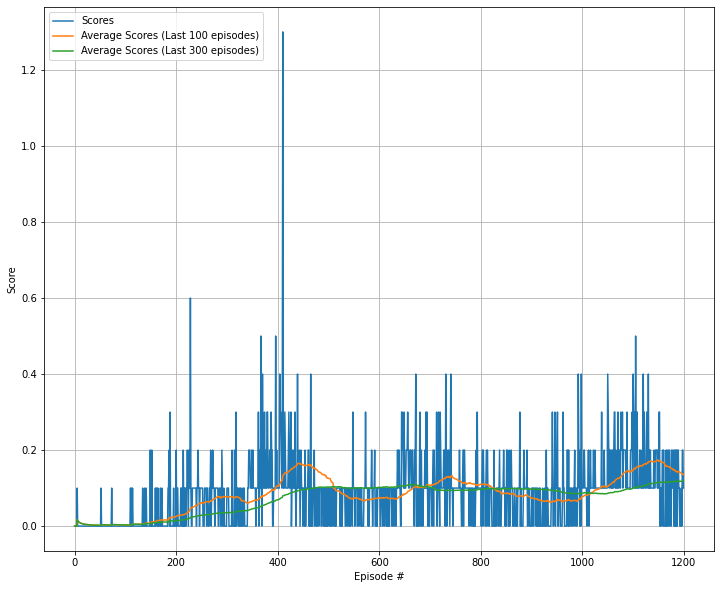

Episode 1200	Average Score: 0.1360	Max Score: 0.5000
Episode 1201	Average Score: 0.1330	Max Score: 0.5000
Episode 1202	Average Score: 0.1300	Max Score: 0.5000
Episode 1203	Average Score: 0.1270	Max Score: 0.5000
Episode 1204	Average Score: 0.1270	Max Score: 0.5000
Episode 1205	Average Score: 0.1280	Max Score: 0.5000
Episode 1206	Average Score: 0.1240	Max Score: 0.4000
Episode 1207	Average Score: 0.1270	Max Score: 0.4000
Episode 1208	Average Score: 0.1260	Max Score: 0.4000
Episode 1209	Average Score: 0.1250	Max Score: 0.4000
Episode 1210	Average Score: 0.1240	Max Score: 0.4000
Episode 1211	Average Score: 0.1240	Max Score: 0.4000
Episode 1212	Average Score: 0.1230	Max Score: 0.4000
Episode 1213	Average Score: 0.1220	Max Score: 0.4000
Episode 1214	Average Score: 0.1200	Max Score: 0.4000
Episode 1215	Average Score: 0.1180	Max Score: 0.4000
Episode 1216	Average Score: 0.1180	Max Score: 0.4000
Episode 1217	Average Score: 0.1180	Max Score: 0.4000
Episode 1218	Average Score: 0.1180	Max Score: 

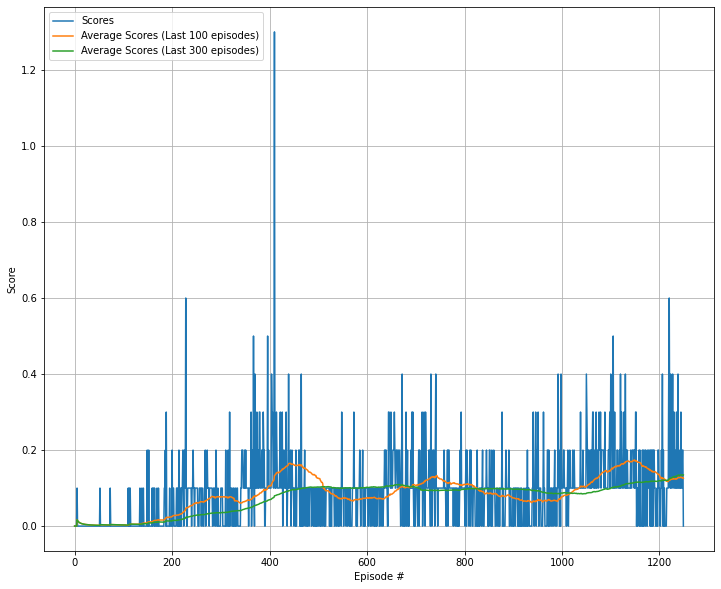

Episode 1250	Average Score: 0.1260	Max Score: 0.6000
Episode 1251	Average Score: 0.1260	Max Score: 0.6000
Episode 1252	Average Score: 0.1240	Max Score: 0.6000
Episode 1253	Average Score: 0.1220	Max Score: 0.6000
Episode 1254	Average Score: 0.1230	Max Score: 0.6000
Episode 1255	Average Score: 0.1230	Max Score: 0.6000
Episode 1256	Average Score: 0.1240	Max Score: 0.6000
Episode 1257	Average Score: 0.1240	Max Score: 0.6000
Episode 1258	Average Score: 0.1240	Max Score: 0.6000
Episode 1259	Average Score: 0.1250	Max Score: 0.6000
Episode 1260	Average Score: 0.1260	Max Score: 0.6000
Episode 1261	Average Score: 0.1250	Max Score: 0.6000
Episode 1262	Average Score: 0.1260	Max Score: 0.6000
Episode 1263	Average Score: 0.1280	Max Score: 0.6000
Episode 1264	Average Score: 0.1320	Max Score: 0.6000
Episode 1265	Average Score: 0.1330	Max Score: 0.6000
Episode 1266	Average Score: 0.1320	Max Score: 0.6000
Episode 1267	Average Score: 0.1330	Max Score: 0.6000
Episode 1268	Average Score: 0.1330	Max Score: 

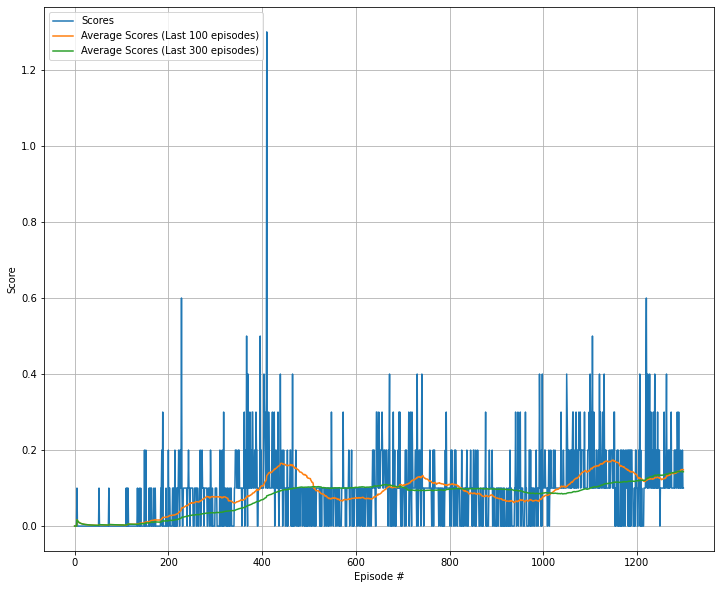

Episode 1300	Average Score: 0.1480	Max Score: 0.6000
Episode 1301	Average Score: 0.1490	Max Score: 0.6000
Episode 1302	Average Score: 0.1500	Max Score: 0.6000
Episode 1303	Average Score: 0.1510	Max Score: 0.6000
Episode 1304	Average Score: 0.1520	Max Score: 0.6000
Episode 1305	Average Score: 0.1510	Max Score: 0.6000
Episode 1306	Average Score: 0.1510	Max Score: 0.6000
Episode 1307	Average Score: 0.1490	Max Score: 0.6000
Episode 1308	Average Score: 0.1500	Max Score: 0.6000
Episode 1309	Average Score: 0.1490	Max Score: 0.6000
Episode 1310	Average Score: 0.1530	Max Score: 0.6000
Episode 1311	Average Score: 0.1530	Max Score: 0.6000
Episode 1312	Average Score: 0.1540	Max Score: 0.6000
Episode 1313	Average Score: 0.1550	Max Score: 0.6000
Episode 1314	Average Score: 0.1570	Max Score: 0.6000
Episode 1315	Average Score: 0.1610	Max Score: 0.6000
Episode 1316	Average Score: 0.1660	Max Score: 0.6000
Episode 1317	Average Score: 0.1670	Max Score: 0.6000
Episode 1318	Average Score: 0.1670	Max Score: 

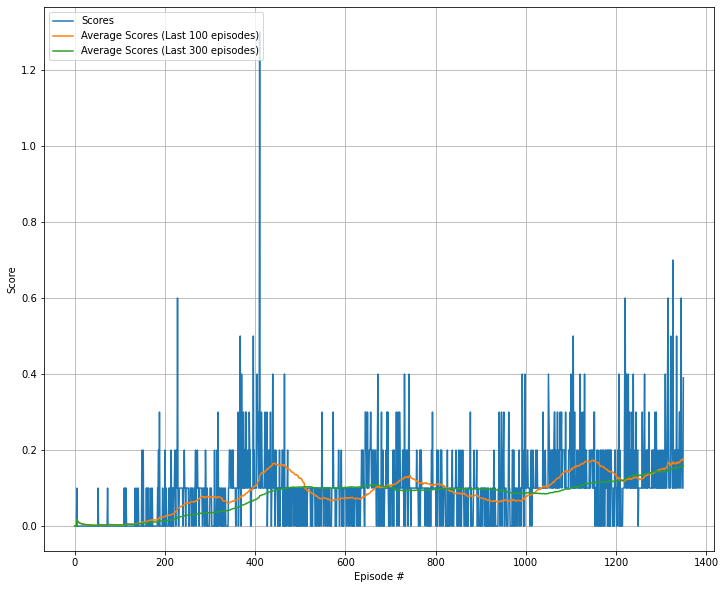

Episode 1350	Average Score: 0.1769	Max Score: 0.7000
Episode 1351	Average Score: 0.1779	Max Score: 0.7000
Episode 1352	Average Score: 0.1809	Max Score: 0.7000
Episode 1353	Average Score: 0.1809	Max Score: 0.7000
Episode 1354	Average Score: 0.1849	Max Score: 0.7000
Episode 1355	Average Score: 0.1849	Max Score: 0.7000
Episode 1356	Average Score: 0.1839	Max Score: 0.7000
Episode 1357	Average Score: 0.1849	Max Score: 0.7000
Episode 1358	Average Score: 0.1849	Max Score: 0.7000
Episode 1359	Average Score: 0.1839	Max Score: 0.7000
Episode 1360	Average Score: 0.1859	Max Score: 0.7000
Episode 1361	Average Score: 0.1859	Max Score: 0.7000
Episode 1362	Average Score: 0.1889	Max Score: 0.7000
Episode 1363	Average Score: 0.1879	Max Score: 0.7000
Episode 1364	Average Score: 0.1849	Max Score: 0.7000
Episode 1365	Average Score: 0.1849	Max Score: 0.7000
Episode 1366	Average Score: 0.1849	Max Score: 0.7000
Episode 1367	Average Score: 0.1849	Max Score: 0.7000
Episode 1368	Average Score: 0.1859	Max Score: 

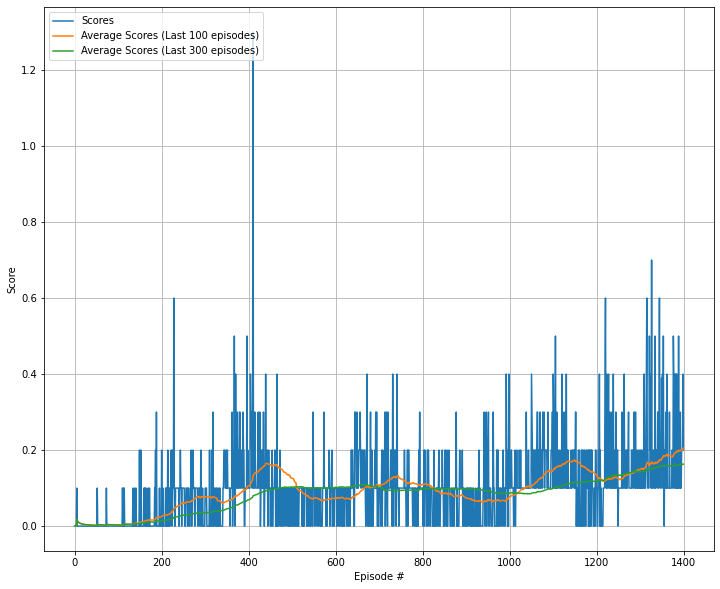

Episode 1400	Average Score: 0.2049	Max Score: 0.7000
Episode 1401	Average Score: 0.2049	Max Score: 0.7000
Episode 1402	Average Score: 0.2049	Max Score: 0.7000
Episode 1403	Average Score: 0.2049	Max Score: 0.7000
Episode 1404	Average Score: 0.2059	Max Score: 0.7000
Episode 1405	Average Score: 0.2069	Max Score: 0.7000
Episode 1406	Average Score: 0.2069	Max Score: 0.7000
Episode 1407	Average Score: 0.2059	Max Score: 0.7000
Episode 1408	Average Score: 0.2059	Max Score: 0.7000
Episode 1409	Average Score: 0.2059	Max Score: 0.7000
Episode 1410	Average Score: 0.2029	Max Score: 0.7000
Episode 1411	Average Score: 0.2069	Max Score: 0.7000
Episode 1412	Average Score: 0.2069	Max Score: 0.7000
Episode 1413	Average Score: 0.2089	Max Score: 0.7000
Episode 1414	Average Score: 0.2079	Max Score: 0.7000
Episode 1415	Average Score: 0.2059	Max Score: 0.7000
Episode 1416	Average Score: 0.2009	Max Score: 0.7000
Episode 1417	Average Score: 0.2019	Max Score: 0.7000
Episode 1418	Average Score: 0.2019	Max Score: 

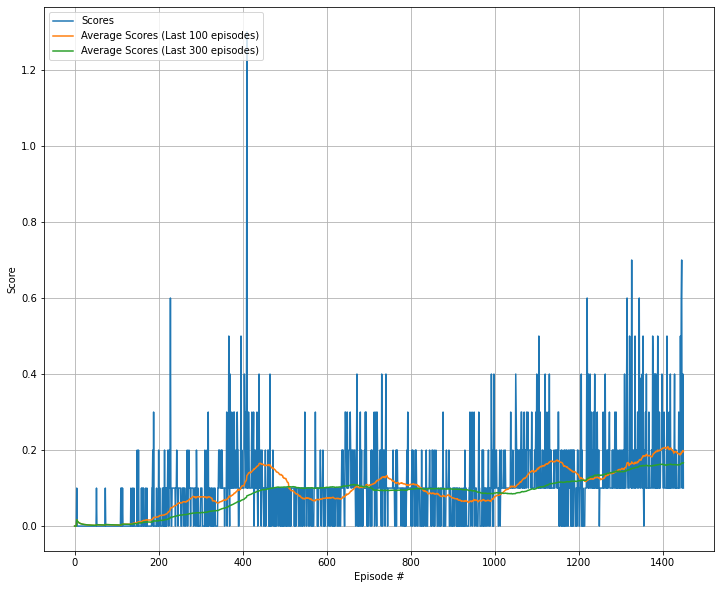

Episode 1450	Average Score: 0.1960	Max Score: 0.7000
Episode 1451	Average Score: 0.1950	Max Score: 0.7000
Episode 1452	Average Score: 0.1940	Max Score: 0.7000
Episode 1453	Average Score: 0.1950	Max Score: 0.7000
Episode 1454	Average Score: 0.1910	Max Score: 0.7000
Episode 1455	Average Score: 0.1920	Max Score: 0.7000
Episode 1456	Average Score: 0.1940	Max Score: 0.7000
Episode 1457	Average Score: 0.1930	Max Score: 0.7000
Episode 1458	Average Score: 0.1930	Max Score: 0.7000
Episode 1459	Average Score: 0.1950	Max Score: 0.7000
Episode 1460	Average Score: 0.1940	Max Score: 0.7000
Episode 1461	Average Score: 0.1980	Max Score: 0.7000
Episode 1462	Average Score: 0.1960	Max Score: 0.7000
Episode 1463	Average Score: 0.1970	Max Score: 0.7000
Episode 1464	Average Score: 0.1980	Max Score: 0.7000
Episode 1465	Average Score: 0.2000	Max Score: 0.7000
Episode 1466	Average Score: 0.2010	Max Score: 0.7000
Episode 1467	Average Score: 0.2030	Max Score: 0.7000
Episode 1468	Average Score: 0.2020	Max Score: 

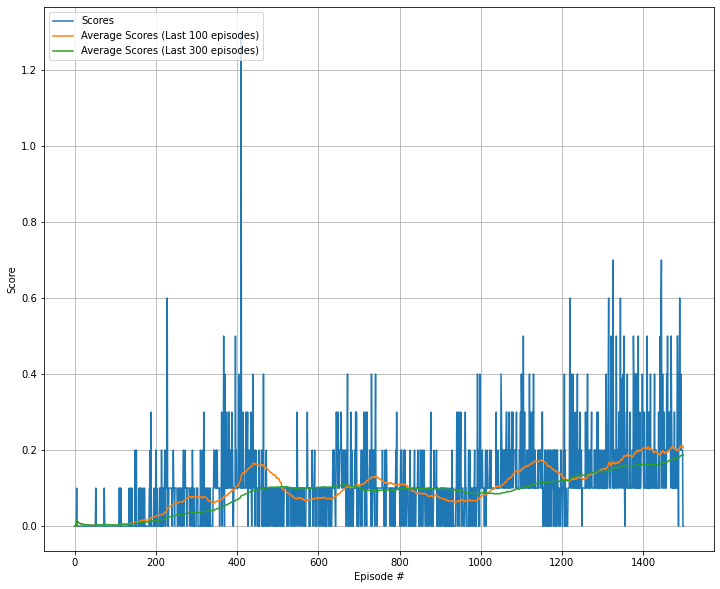

Episode 1500	Average Score: 0.2060	Max Score: 0.7000
Episode 1501	Average Score: 0.2060	Max Score: 0.7000
Episode 1502	Average Score: 0.2060	Max Score: 0.7000
Episode 1503	Average Score: 0.2060	Max Score: 0.7000
Episode 1504	Average Score: 0.2060	Max Score: 0.7000
Episode 1505	Average Score: 0.2060	Max Score: 0.7000
Episode 1506	Average Score: 0.2060	Max Score: 0.7000
Episode 1507	Average Score: 0.2060	Max Score: 0.7000
Episode 1508	Average Score: 0.2070	Max Score: 0.7000
Episode 1509	Average Score: 0.2080	Max Score: 0.7000
Episode 1510	Average Score: 0.2080	Max Score: 0.7000
Episode 1511	Average Score: 0.2080	Max Score: 0.7000
Episode 1512	Average Score: 0.2090	Max Score: 0.7000
Episode 1513	Average Score: 0.2070	Max Score: 0.7000
Episode 1514	Average Score: 0.2080	Max Score: 0.7000
Episode 1515	Average Score: 0.2110	Max Score: 0.7000
Episode 1516	Average Score: 0.2110	Max Score: 0.7000
Episode 1517	Average Score: 0.2090	Max Score: 0.7000
Episode 1518	Average Score: 0.2110	Max Score: 

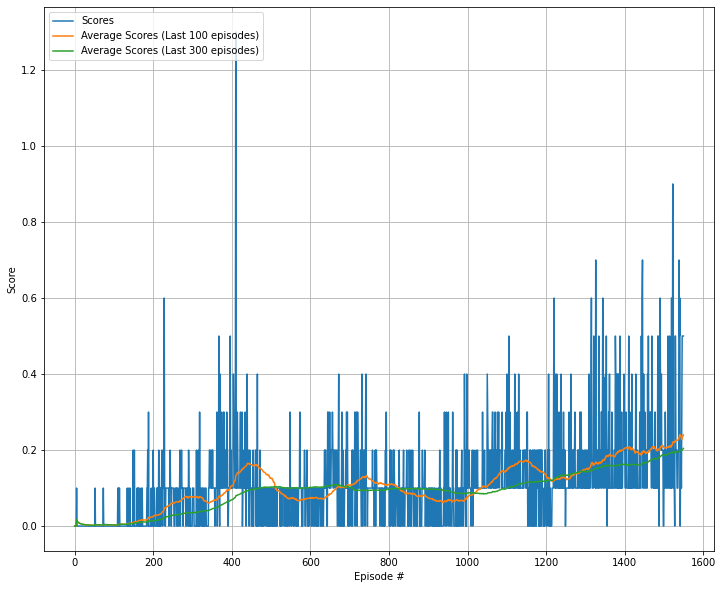

Episode 1550	Average Score: 0.2400	Max Score: 0.9000
Episode 1551	Average Score: 0.2440	Max Score: 0.9000
Episode 1552	Average Score: 0.2470	Max Score: 0.9000
Episode 1553	Average Score: 0.2470	Max Score: 0.9000
Episode 1554	Average Score: 0.2470	Max Score: 0.9000
Episode 1555	Average Score: 0.2560	Max Score: 1.1000
Episode 1556	Average Score: 0.2610	Max Score: 1.1000
Episode 1557	Average Score: 0.2610	Max Score: 1.1000
Episode 1558	Average Score: 0.2640	Max Score: 1.1000
Episode 1559	Average Score: 0.2610	Max Score: 1.1000
Episode 1560	Average Score: 0.2610	Max Score: 1.1000
Episode 1561	Average Score: 0.2580	Max Score: 1.1000
Episode 1562	Average Score: 0.2620	Max Score: 1.1000
Episode 1563	Average Score: 0.2640	Max Score: 1.1000
Episode 1564	Average Score: 0.2650	Max Score: 1.1000
Episode 1565	Average Score: 0.2650	Max Score: 1.1000
Episode 1566	Average Score: 0.2640	Max Score: 1.1000
Episode 1567	Average Score: 0.2630	Max Score: 1.1000
Episode 1568	Average Score: 0.2660	Max Score: 

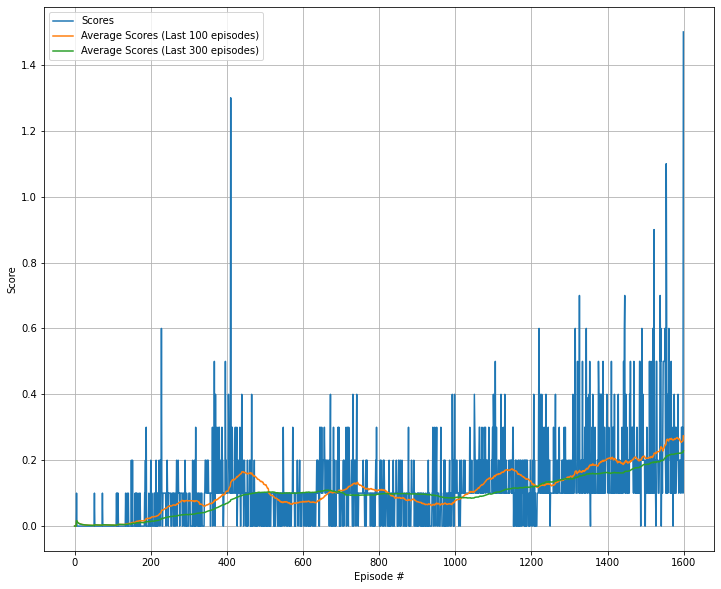

Episode 1600	Average Score: 0.2740	Max Score: 1.5000
Episode 1601	Average Score: 0.2750	Max Score: 1.5000
Episode 1602	Average Score: 0.2770	Max Score: 1.5000
Episode 1603	Average Score: 0.2780	Max Score: 1.5000
Episode 1604	Average Score: 0.2760	Max Score: 1.5000
Episode 1605	Average Score: 0.2830	Max Score: 1.5000
Episode 1606	Average Score: 0.2870	Max Score: 1.5000
Episode 1607	Average Score: 0.2870	Max Score: 1.5000
Episode 1608	Average Score: 0.2900	Max Score: 1.5000
Episode 1609	Average Score: 0.2890	Max Score: 1.5000
Episode 1610	Average Score: 0.2880	Max Score: 1.5000
Episode 1611	Average Score: 0.2880	Max Score: 1.5000
Episode 1612	Average Score: 0.2890	Max Score: 1.5000
Episode 1613	Average Score: 0.2890	Max Score: 1.5000
Episode 1614	Average Score: 0.2920	Max Score: 1.5000
Episode 1615	Average Score: 0.2880	Max Score: 1.5000
Episode 1616	Average Score: 0.2880	Max Score: 1.5000
Episode 1617	Average Score: 0.2880	Max Score: 1.5000
Episode 1618	Average Score: 0.2880	Max Score: 

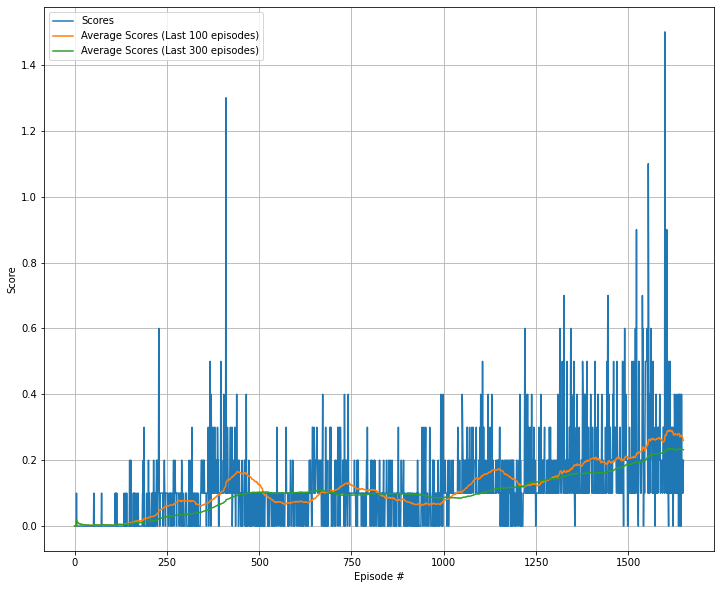

Episode 1650	Average Score: 0.2600	Max Score: 1.5000
Episode 1651	Average Score: 0.2570	Max Score: 1.5000
Episode 1652	Average Score: 0.2520	Max Score: 1.5000
Episode 1653	Average Score: 0.2530	Max Score: 1.5000
Episode 1654	Average Score: 0.2540	Max Score: 1.5000
Episode 1655	Average Score: 0.2450	Max Score: 1.5000
Episode 1656	Average Score: 0.2420	Max Score: 1.5000
Episode 1657	Average Score: 0.2440	Max Score: 1.5000
Episode 1658	Average Score: 0.2420	Max Score: 1.5000
Episode 1659	Average Score: 0.2420	Max Score: 1.5000
Episode 1660	Average Score: 0.2410	Max Score: 1.5000
Episode 1661	Average Score: 0.2410	Max Score: 1.5000
Episode 1662	Average Score: 0.2360	Max Score: 1.5000
Episode 1663	Average Score: 0.2350	Max Score: 1.5000
Episode 1664	Average Score: 0.2330	Max Score: 1.5000
Episode 1665	Average Score: 0.2300	Max Score: 1.5000
Episode 1666	Average Score: 0.2300	Max Score: 1.5000
Episode 1667	Average Score: 0.2290	Max Score: 1.5000
Episode 1668	Average Score: 0.2250	Max Score: 

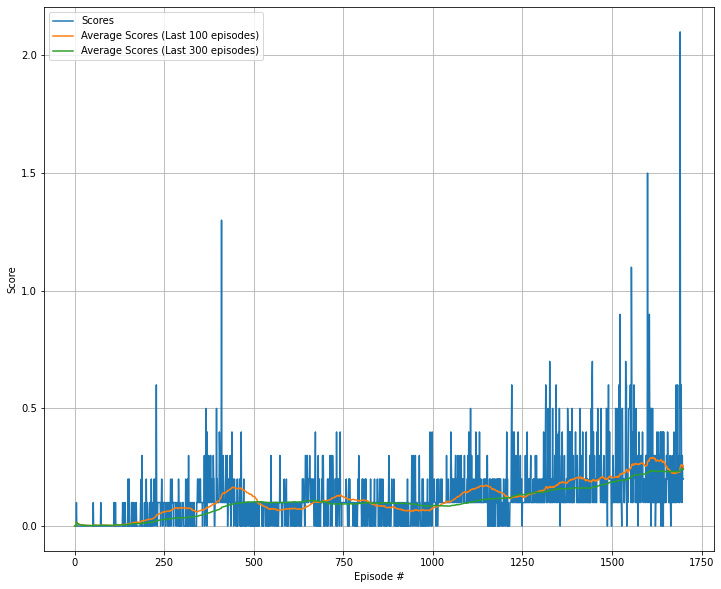

Episode 1700	Average Score: 0.2450	Max Score: 2.1000
Episode 1701	Average Score: 0.2450	Max Score: 2.1000
Episode 1702	Average Score: 0.2430	Max Score: 2.1000
Episode 1703	Average Score: 0.2440	Max Score: 2.1000
Episode 1704	Average Score: 0.2550	Max Score: 2.1000
Episode 1705	Average Score: 0.2470	Max Score: 2.1000
Episode 1706	Average Score: 0.2430	Max Score: 2.1000
Episode 1707	Average Score: 0.2460	Max Score: 2.1000
Episode 1708	Average Score: 0.2430	Max Score: 2.1000
Episode 1709	Average Score: 0.2530	Max Score: 2.1000
Episode 1710	Average Score: 0.2540	Max Score: 2.1000
Episode 1711	Average Score: 0.2510	Max Score: 2.1000
Episode 1712	Average Score: 0.2480	Max Score: 2.1000
Episode 1713	Average Score: 0.2500	Max Score: 2.1000
Episode 1714	Average Score: 0.2460	Max Score: 2.1000
Episode 1715	Average Score: 0.2460	Max Score: 2.1000
Episode 1716	Average Score: 0.2480	Max Score: 2.1000
Episode 1717	Average Score: 0.2500	Max Score: 2.1000
Episode 1718	Average Score: 0.2480	Max Score: 

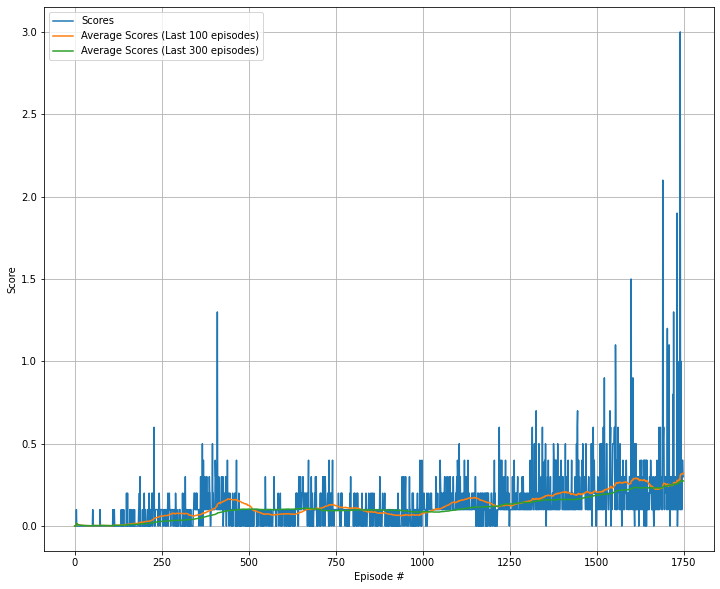

Episode 1750	Average Score: 0.3220	Max Score: 3.0000
Episode 1751	Average Score: 0.3210	Max Score: 3.0000
Episode 1752	Average Score: 0.3210	Max Score: 3.0000
Episode 1753	Average Score: 0.3190	Max Score: 3.0000
Episode 1754	Average Score: 0.3210	Max Score: 3.0000
Episode 1755	Average Score: 0.3640	Max Score: 4.5000
Episode 1756	Average Score: 0.3610	Max Score: 4.5000
Episode 1757	Average Score: 0.3660	Max Score: 4.5000
Episode 1758	Average Score: 0.3650	Max Score: 4.5000
Episode 1759	Average Score: 0.3700	Max Score: 4.5000
Episode 1760	Average Score: 0.3750	Max Score: 4.5000
Episode 1761	Average Score: 0.3850	Max Score: 4.5000
Episode 1762	Average Score: 0.3850	Max Score: 4.5000
Episode 1763	Average Score: 0.3820	Max Score: 4.5000
Episode 1764	Average Score: 0.3820	Max Score: 4.5000
Episode 1765	Average Score: 0.3830	Max Score: 4.5000
Episode 1766	Average Score: 0.3830	Max Score: 4.5000
Episode 1767	Average Score: 0.3830	Max Score: 4.5000
Episode 1768	Average Score: 0.3830	Max Score: 

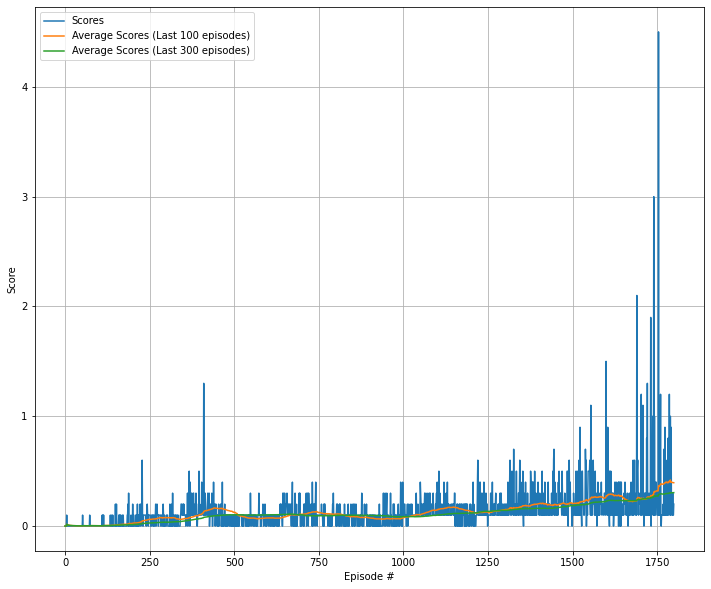

Episode 1800	Average Score: 0.3950	Max Score: 4.5000
Episode 1801	Average Score: 0.3920	Max Score: 4.5000
Episode 1802	Average Score: 0.3910	Max Score: 4.5000
Episode 1803	Average Score: 0.3880	Max Score: 4.5000
Episode 1804	Average Score: 0.3760	Max Score: 4.5000
Episode 1805	Average Score: 0.3760	Max Score: 4.5000
Episode 1806	Average Score: 0.3760	Max Score: 4.5000
Episode 1807	Average Score: 0.3720	Max Score: 4.5000
Episode 1808	Average Score: 0.3720	Max Score: 4.5000
Episode 1809	Average Score: 0.3620	Max Score: 4.5000
Episode 1810	Average Score: 0.3630	Max Score: 4.5000
Episode 1811	Average Score: 0.3650	Max Score: 4.5000
Episode 1812	Average Score: 0.3650	Max Score: 4.5000
Episode 1813	Average Score: 0.3620	Max Score: 4.5000
Episode 1814	Average Score: 0.3610	Max Score: 4.5000
Episode 1815	Average Score: 0.3630	Max Score: 4.5000
Episode 1816	Average Score: 0.3620	Max Score: 4.5000
Episode 1817	Average Score: 0.3590	Max Score: 4.5000
Episode 1818	Average Score: 0.3580	Max Score: 

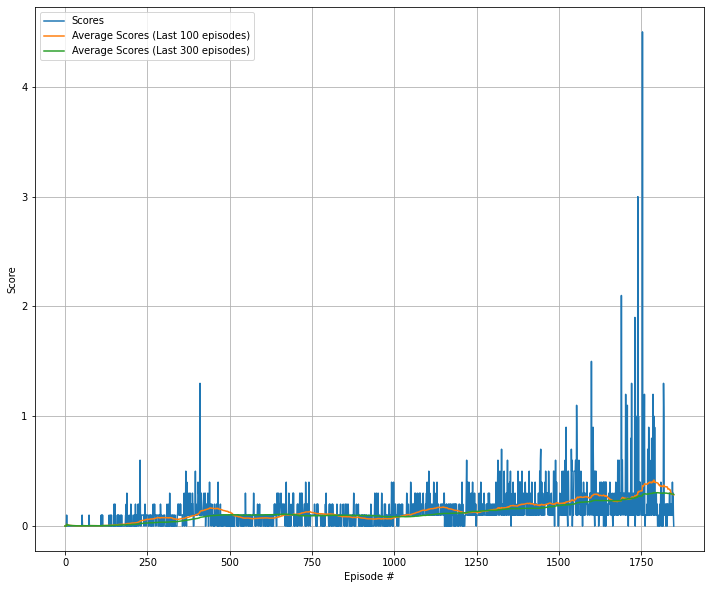

Episode 1850	Average Score: 0.2840	Max Score: 4.5000
Episode 1851	Average Score: 0.2840	Max Score: 4.5000
Episode 1852	Average Score: 0.2850	Max Score: 4.5000
Episode 1853	Average Score: 0.2850	Max Score: 4.5000
Episode 1854	Average Score: 0.2820	Max Score: 4.5000
Episode 1855	Average Score: 0.2380	Max Score: 1.3000
Episode 1856	Average Score: 0.2380	Max Score: 1.3000
Episode 1857	Average Score: 0.2310	Max Score: 1.3000
Episode 1858	Average Score: 0.2320	Max Score: 1.3000
Episode 1859	Average Score: 0.2270	Max Score: 1.3000
Episode 1860	Average Score: 0.2220	Max Score: 1.3000
Episode 1861	Average Score: 0.2110	Max Score: 1.3000
Episode 1862	Average Score: 0.2110	Max Score: 1.3000
Episode 1863	Average Score: 0.2120	Max Score: 1.3000
Episode 1864	Average Score: 0.2120	Max Score: 1.3000
Episode 1865	Average Score: 0.2120	Max Score: 1.3000
Episode 1866	Average Score: 0.2160	Max Score: 1.3000
Episode 1867	Average Score: 0.2160	Max Score: 1.3000
Episode 1868	Average Score: 0.2250	Max Score: 

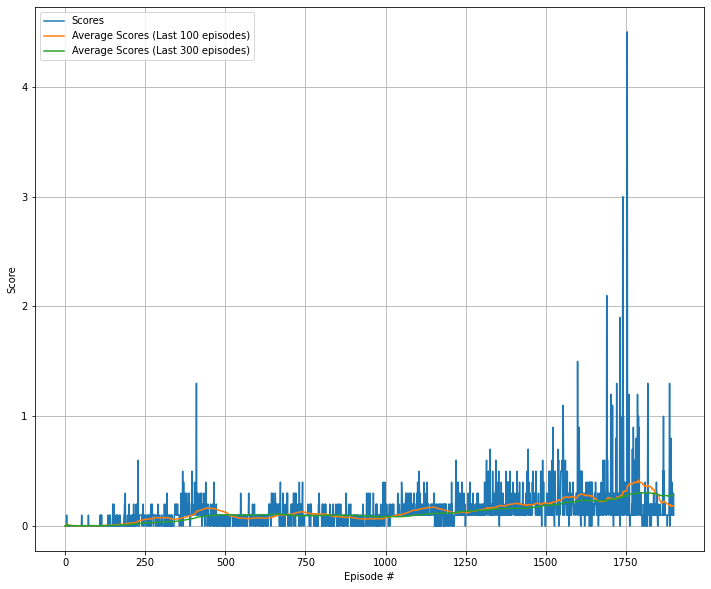

Episode 1900	Average Score: 0.1830	Max Score: 1.3000
Episode 1901	Average Score: 0.1980	Max Score: 1.5000
Episode 1902	Average Score: 0.2150	Max Score: 1.7000
Episode 1903	Average Score: 0.2170	Max Score: 1.7000
Episode 1904	Average Score: 0.2170	Max Score: 1.7000
Episode 1905	Average Score: 0.2160	Max Score: 1.7000
Episode 1906	Average Score: 0.2190	Max Score: 1.7000
Episode 1907	Average Score: 0.2190	Max Score: 1.7000
Episode 1908	Average Score: 0.2180	Max Score: 1.7000
Episode 1909	Average Score: 0.2180	Max Score: 1.7000
Episode 1910	Average Score: 0.2200	Max Score: 1.7000
Episode 1911	Average Score: 0.2170	Max Score: 1.7000
Episode 1912	Average Score: 0.2180	Max Score: 1.7000
Episode 1913	Average Score: 0.2210	Max Score: 1.7000
Episode 1914	Average Score: 0.2210	Max Score: 1.7000
Episode 1915	Average Score: 0.2190	Max Score: 1.7000
Episode 1916	Average Score: 0.2190	Max Score: 1.7000
Episode 1917	Average Score: 0.2270	Max Score: 1.7000
Episode 1918	Average Score: 0.2290	Max Score: 

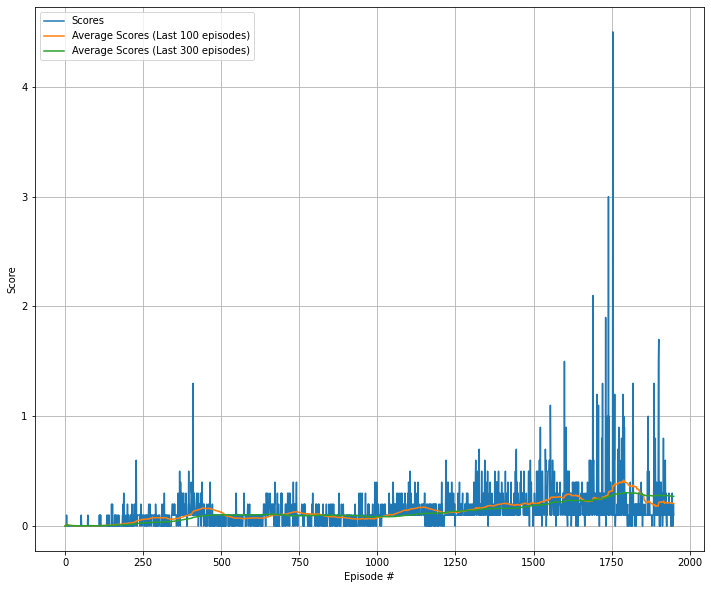

Episode 1950	Average Score: 0.2060	Max Score: 1.7000
Episode 1951	Average Score: 0.2060	Max Score: 1.7000
Episode 1952	Average Score: 0.2050	Max Score: 1.7000
Episode 1953	Average Score: 0.2060	Max Score: 1.7000
Episode 1954	Average Score: 0.2060	Max Score: 1.7000
Episode 1955	Average Score: 0.2060	Max Score: 1.7000
Episode 1956	Average Score: 0.2060	Max Score: 1.7000
Episode 1957	Average Score: 0.2060	Max Score: 1.7000
Episode 1958	Average Score: 0.2050	Max Score: 1.7000
Episode 1959	Average Score: 0.2080	Max Score: 1.7000
Episode 1960	Average Score: 0.2080	Max Score: 1.7000
Episode 1961	Average Score: 0.2080	Max Score: 1.7000
Episode 1962	Average Score: 0.2080	Max Score: 1.7000
Episode 1963	Average Score: 0.2070	Max Score: 1.7000
Episode 1964	Average Score: 0.2070	Max Score: 1.7000
Episode 1965	Average Score: 0.2070	Max Score: 1.7000
Episode 1966	Average Score: 0.2020	Max Score: 1.7000
Episode 1967	Average Score: 0.2010	Max Score: 1.7000
Episode 1968	Average Score: 0.1920	Max Score: 

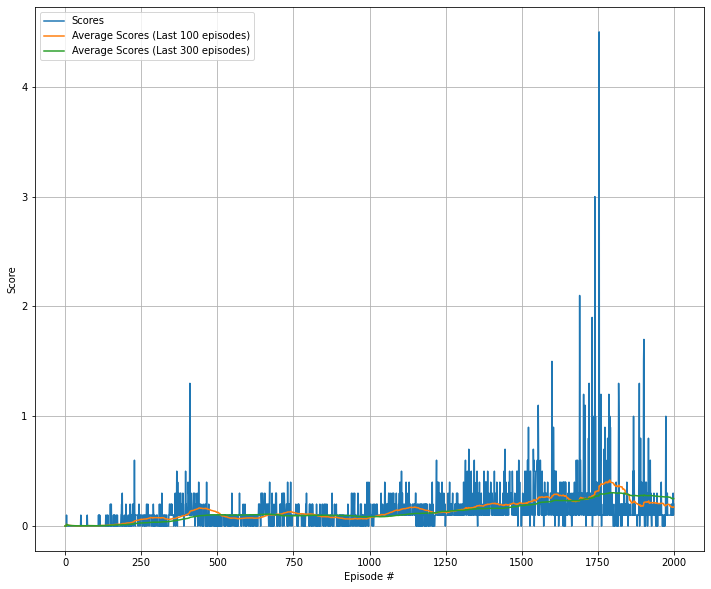

Episode 2000	Average Score: 0.1730	Max Score: 1.7000
Episode 2001	Average Score: 0.1630	Max Score: 1.7000
Episode 2002	Average Score: 0.1480	Max Score: 1.0000
Episode 2003	Average Score: 0.1480	Max Score: 1.0000
Episode 2004	Average Score: 0.1490	Max Score: 1.0000
Episode 2005	Average Score: 0.1560	Max Score: 1.0000
Episode 2006	Average Score: 0.1520	Max Score: 1.0000
Episode 2007	Average Score: 0.1530	Max Score: 1.0000
Episode 2008	Average Score: 0.1680	Max Score: 1.6000
Episode 2009	Average Score: 0.1680	Max Score: 1.6000
Episode 2010	Average Score: 0.1660	Max Score: 1.6000
Episode 2011	Average Score: 0.1660	Max Score: 1.6000
Episode 2012	Average Score: 0.1660	Max Score: 1.6000
Episode 2013	Average Score: 0.1680	Max Score: 1.6000
Episode 2014	Average Score: 0.1680	Max Score: 1.6000
Episode 2015	Average Score: 0.1670	Max Score: 1.6000
Episode 2016	Average Score: 0.1660	Max Score: 1.6000
Episode 2017	Average Score: 0.1590	Max Score: 1.6000
Episode 2018	Average Score: 0.1580	Max Score: 

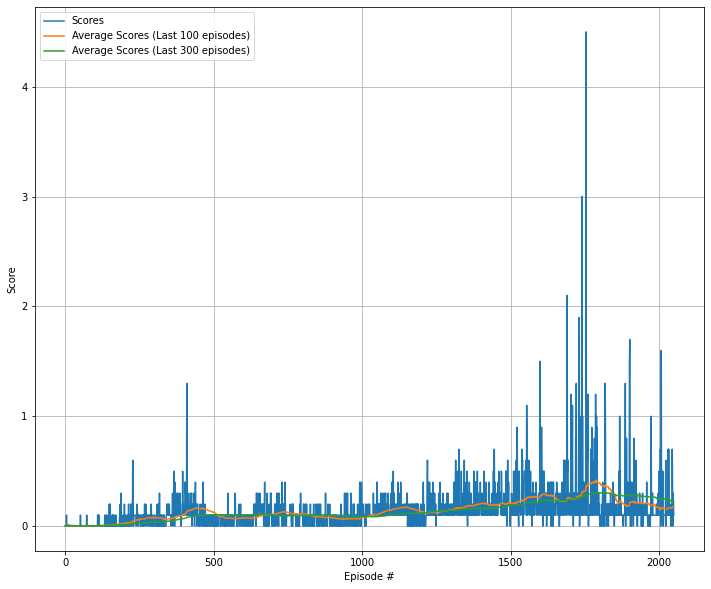

Episode 2050	Average Score: 0.1739	Max Score: 1.6000
Episode 2051	Average Score: 0.1739	Max Score: 1.6000
Episode 2052	Average Score: 0.1739	Max Score: 1.6000
Episode 2053	Average Score: 0.1729	Max Score: 1.6000
Episode 2054	Average Score: 0.1739	Max Score: 1.6000
Episode 2055	Average Score: 0.1739	Max Score: 1.6000
Episode 2056	Average Score: 0.1729	Max Score: 1.6000
Episode 2057	Average Score: 0.1729	Max Score: 1.6000
Episode 2058	Average Score: 0.1729	Max Score: 1.6000
Episode 2059	Average Score: 0.1699	Max Score: 1.6000
Episode 2060	Average Score: 0.1699	Max Score: 1.6000
Episode 2061	Average Score: 0.1709	Max Score: 1.6000
Episode 2062	Average Score: 0.1709	Max Score: 1.6000
Episode 2063	Average Score: 0.1719	Max Score: 1.6000
Episode 2064	Average Score: 0.1719	Max Score: 1.6000
Episode 2065	Average Score: 0.1729	Max Score: 1.6000
Episode 2066	Average Score: 0.1729	Max Score: 1.6000
Episode 2067	Average Score: 0.1739	Max Score: 1.6000
Episode 2068	Average Score: 0.1739	Max Score: 

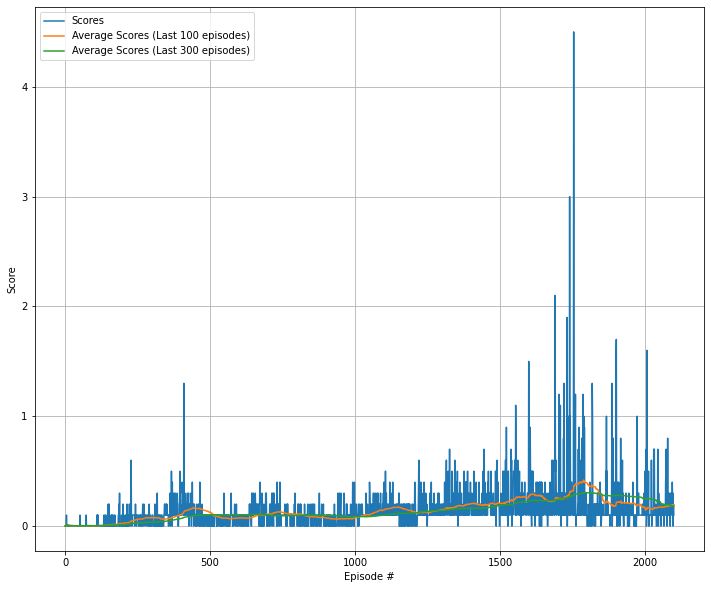

Episode 2100	Average Score: 0.1919	Max Score: 1.6000
Episode 2101	Average Score: 0.1879	Max Score: 1.6000
Episode 2102	Average Score: 0.1869	Max Score: 1.6000
Episode 2103	Average Score: 0.1879	Max Score: 1.6000
Episode 2104	Average Score: 0.1929	Max Score: 1.6000
Episode 2105	Average Score: 0.1879	Max Score: 1.6000
Episode 2106	Average Score: 0.1899	Max Score: 1.6000
Episode 2107	Average Score: 0.1889	Max Score: 1.6000
Episode 2108	Average Score: 0.1799	Max Score: 0.8000
Episode 2109	Average Score: 0.1799	Max Score: 0.8000
Episode 2110	Average Score: 0.1809	Max Score: 0.8000
Episode 2111	Average Score: 0.1818	Max Score: 0.8000
Episode 2112	Average Score: 0.1838	Max Score: 0.8000
Episode 2113	Average Score: 0.1808	Max Score: 0.8000
Episode 2114	Average Score: 0.1868	Max Score: 0.8000
Episode 2115	Average Score: 0.1898	Max Score: 0.8000
Episode 2116	Average Score: 0.1908	Max Score: 0.8000
Episode 2117	Average Score: 0.1908	Max Score: 0.8000
Episode 2118	Average Score: 0.1908	Max Score: 

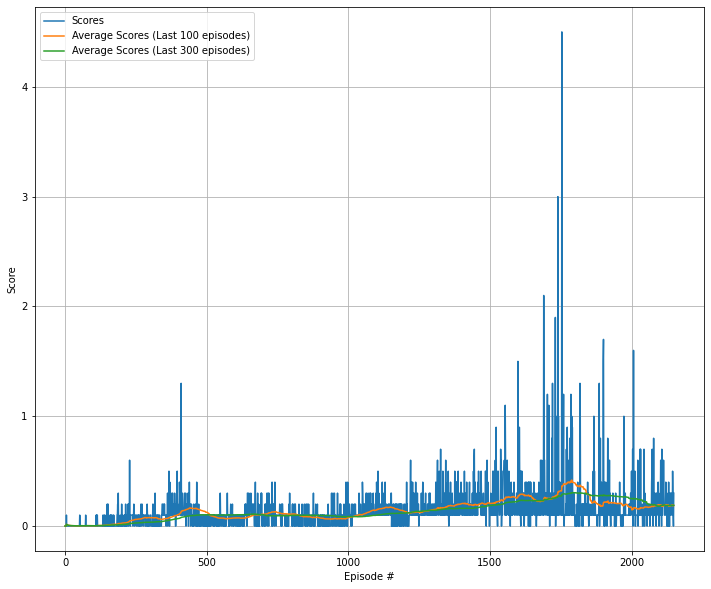

Episode 2150	Average Score: 0.1879	Max Score: 0.8000
Episode 2151	Average Score: 0.1879	Max Score: 0.8000
Episode 2152	Average Score: 0.1889	Max Score: 0.8000
Episode 2153	Average Score: 0.1889	Max Score: 0.8000
Episode 2154	Average Score: 0.1879	Max Score: 0.8000
Episode 2155	Average Score: 0.1899	Max Score: 0.8000
Episode 2156	Average Score: 0.1929	Max Score: 0.8000
Episode 2157	Average Score: 0.1939	Max Score: 0.8000
Episode 2158	Average Score: 0.1959	Max Score: 0.8000
Episode 2159	Average Score: 0.1969	Max Score: 0.8000
Episode 2160	Average Score: 0.1999	Max Score: 0.8000
Episode 2161	Average Score: 0.1999	Max Score: 0.8000
Episode 2162	Average Score: 0.2029	Max Score: 0.8000
Episode 2163	Average Score: 0.2019	Max Score: 0.8000
Episode 2164	Average Score: 0.2029	Max Score: 0.8000
Episode 2165	Average Score: 0.2019	Max Score: 0.8000
Episode 2166	Average Score: 0.2019	Max Score: 0.8000
Episode 2167	Average Score: 0.2029	Max Score: 0.8000
Episode 2168	Average Score: 0.2029	Max Score: 

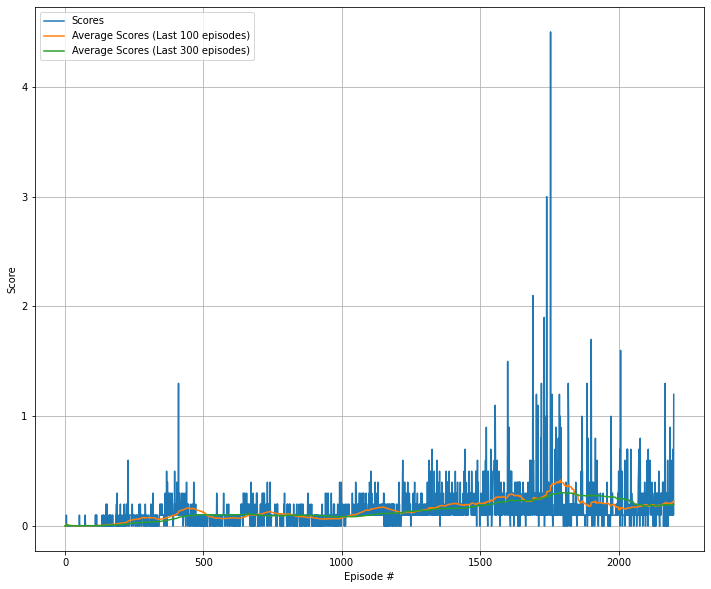

Episode 2200	Average Score: 0.2299	Max Score: 1.3000
Episode 2201	Average Score: 0.2299	Max Score: 1.3000
Episode 2202	Average Score: 0.2319	Max Score: 1.3000
Episode 2203	Average Score: 0.2309	Max Score: 1.3000
Episode 2204	Average Score: 0.2329	Max Score: 1.3000
Episode 2205	Average Score: 0.2319	Max Score: 1.3000
Episode 2206	Average Score: 0.2309	Max Score: 1.3000
Episode 2207	Average Score: 0.2319	Max Score: 1.3000
Episode 2208	Average Score: 0.2279	Max Score: 1.3000
Episode 2209	Average Score: 0.2299	Max Score: 1.3000
Episode 2210	Average Score: 0.2279	Max Score: 1.3000
Episode 2211	Average Score: 0.2270	Max Score: 1.3000
Episode 2212	Average Score: 0.2250	Max Score: 1.3000
Episode 2213	Average Score: 0.2240	Max Score: 1.3000
Episode 2214	Average Score: 0.2190	Max Score: 1.3000
Episode 2215	Average Score: 0.2220	Max Score: 1.3000
Episode 2216	Average Score: 0.2220	Max Score: 1.3000
Episode 2217	Average Score: 0.2220	Max Score: 1.3000
Episode 2218	Average Score: 0.2240	Max Score: 

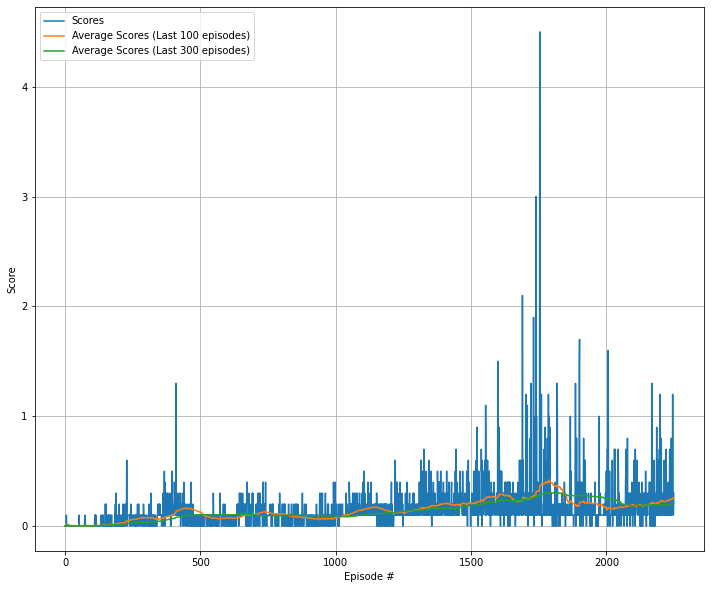

Episode 2250	Average Score: 0.2570	Max Score: 1.3000
Episode 2251	Average Score: 0.2590	Max Score: 1.3000
Episode 2252	Average Score: 0.2590	Max Score: 1.3000
Episode 2253	Average Score: 0.2590	Max Score: 1.3000
Episode 2254	Average Score: 0.2590	Max Score: 1.3000
Episode 2255	Average Score: 0.2570	Max Score: 1.3000
Episode 2256	Average Score: 0.2560	Max Score: 1.3000
Episode 2257	Average Score: 0.2550	Max Score: 1.3000
Episode 2258	Average Score: 0.2530	Max Score: 1.3000
Episode 2259	Average Score: 0.2610	Max Score: 1.3000
Episode 2260	Average Score: 0.2580	Max Score: 1.3000
Episode 2261	Average Score: 0.2590	Max Score: 1.3000
Episode 2262	Average Score: 0.2560	Max Score: 1.3000
Episode 2263	Average Score: 0.2570	Max Score: 1.3000
Episode 2264	Average Score: 0.2560	Max Score: 1.3000
Episode 2265	Average Score: 0.2580	Max Score: 1.3000
Episode 2266	Average Score: 0.2590	Max Score: 1.3000
Episode 2267	Average Score: 0.2700	Max Score: 1.3000
Episode 2268	Average Score: 0.2710	Max Score: 

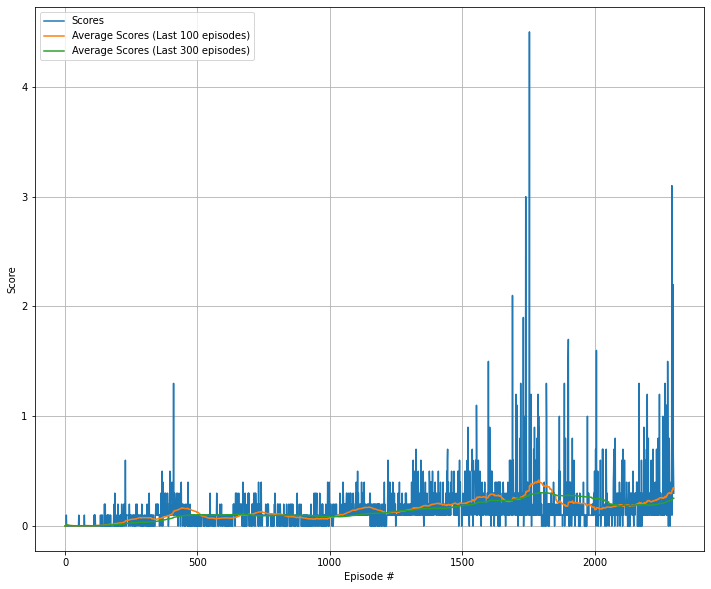

Episode 2300	Average Score: 0.3410	Max Score: 3.1000
Episode 2301	Average Score: 0.3410	Max Score: 3.1000
Episode 2302	Average Score: 0.3390	Max Score: 3.1000
Episode 2303	Average Score: 0.3380	Max Score: 3.1000
Episode 2304	Average Score: 0.3340	Max Score: 3.1000
Episode 2305	Average Score: 0.3370	Max Score: 3.1000
Episode 2306	Average Score: 0.3570	Max Score: 3.1000
Episode 2307	Average Score: 0.3580	Max Score: 3.1000
Episode 2308	Average Score: 0.3600	Max Score: 3.1000
Episode 2309	Average Score: 0.3670	Max Score: 3.1000
Episode 2310	Average Score: 0.3680	Max Score: 3.1000
Episode 2311	Average Score: 0.3690	Max Score: 3.1000
Episode 2312	Average Score: 0.3760	Max Score: 3.1000
Episode 2313	Average Score: 0.3830	Max Score: 3.1000
Episode 2314	Average Score: 0.3950	Max Score: 3.1000
Episode 2315	Average Score: 0.3900	Max Score: 3.1000
Episode 2316	Average Score: 0.3890	Max Score: 3.1000
Episode 2317	Average Score: 0.3890	Max Score: 3.1000
Episode 2318	Average Score: 0.3950	Max Score: 

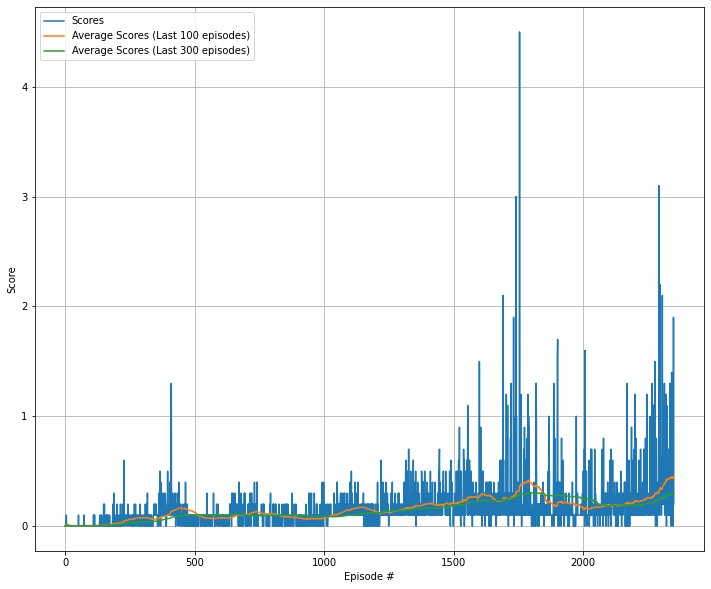

Episode 2350	Average Score: 0.4530	Max Score: 3.1000
Episode 2351	Average Score: 0.4570	Max Score: 3.1000
Episode 2352	Average Score: 0.4630	Max Score: 3.1000
Episode 2353	Average Score: 0.4690	Max Score: 3.1000
Episode 2354	Average Score: 0.4680	Max Score: 3.1000
Episode 2355	Average Score: 0.4670	Max Score: 3.1000
Episode 2356	Average Score: 0.4660	Max Score: 3.1000
Episode 2357	Average Score: 0.4660	Max Score: 3.1000
Episode 2358	Average Score: 0.4670	Max Score: 3.1000
Episode 2359	Average Score: 0.4670	Max Score: 3.1000
Episode 2360	Average Score: 0.4670	Max Score: 3.1000
Episode 2361	Average Score: 0.4650	Max Score: 3.1000
Episode 2362	Average Score: 0.4790	Max Score: 3.1000
Episode 2363	Average Score: 0.4790	Max Score: 3.1000
Episode 2364	Average Score: 0.4780	Max Score: 3.1000
Episode 2365	Average Score: 0.4760	Max Score: 3.1000
Episode 2366	Average Score: 0.4820	Max Score: 3.1000
Episode 2367	Average Score: 0.4890	Max Score: 3.1000
Episode 2368	Average Score: 0.4880	Max Score: 

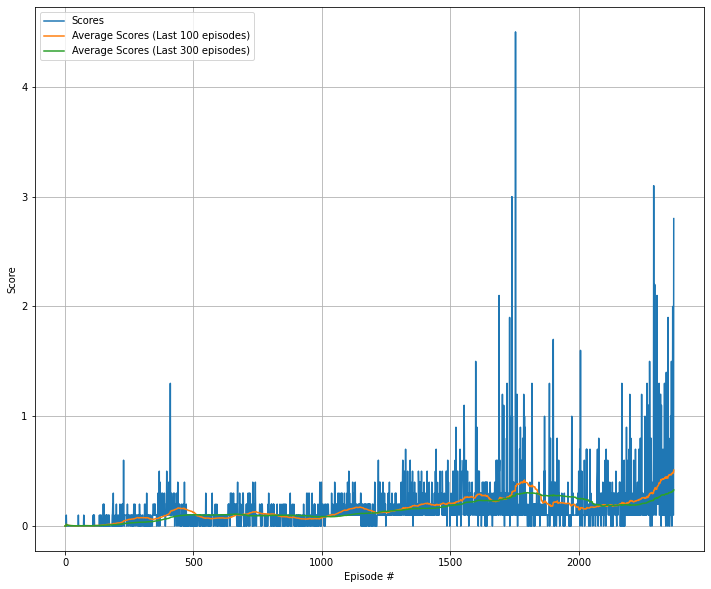

Episode 2372	Average Score: 0.5030	Max Score: 3.1000
Episode 2373	Average Score: 0.5030	Max Score: 3.1000
Episode 2374	Average Score: 0.4930	Max Score: 3.1000
Episode 2375	Average Score: 0.4930	Max Score: 3.1000
Episode 2376	Average Score: 0.4920	Max Score: 3.1000
Episode 2377	Average Score: 0.4780	Max Score: 3.1000
Episode 2378	Average Score: 0.4730	Max Score: 3.1000
Episode 2379	Average Score: 0.4740	Max Score: 3.1000
Episode 2380	Average Score: 0.4810	Max Score: 3.1000
Episode 2381	Average Score: 0.4810	Max Score: 3.1000
Episode 2382	Average Score: 0.4950	Max Score: 3.1000
Episode 2383	Average Score: 0.5139	Max Score: 3.1000
Episode 2384	Average Score: 0.5109	Max Score: 3.1000
Episode 2385	Average Score: 0.5109	Max Score: 3.1000
Episode 2386	Average Score: 0.5119	Max Score: 3.1000
Episode 2387	Average Score: 0.5119	Max Score: 3.1000
Episode 2388	Average Score: 0.5119	Max Score: 3.1000
Episode 2389	Average Score: 0.5239	Max Score: 3.1000
Episode 2390	Average Score: 0.5299	Max Score: 

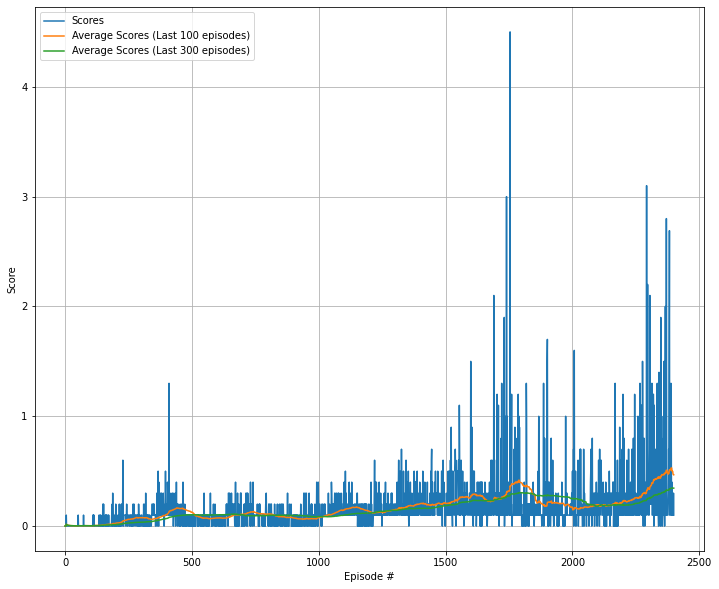

Episode 2400	Average Score: 0.4669	Max Score: 2.8000
Episode 2401	Average Score: 0.4669	Max Score: 2.8000
Episode 2402	Average Score: 0.4699	Max Score: 2.8000
Episode 2403	Average Score: 0.4699	Max Score: 2.8000
Episode 2404	Average Score: 0.4669	Max Score: 2.8000
Episode 2405	Average Score: 0.4659	Max Score: 2.8000
Episode 2406	Average Score: 0.4459	Max Score: 2.8000
Episode 2407	Average Score: 0.4459	Max Score: 2.8000
Episode 2408	Average Score: 0.4419	Max Score: 2.8000
Episode 2409	Average Score: 0.4469	Max Score: 2.8000
Episode 2410	Average Score: 0.4479	Max Score: 2.8000
Episode 2411	Average Score: 0.4579	Max Score: 2.8000
Episode 2412	Average Score: 0.4689	Max Score: 2.8000
Episode 2413	Average Score: 0.4619	Max Score: 2.8000
Episode 2414	Average Score: 0.4509	Max Score: 2.8000
Episode 2415	Average Score: 0.4509	Max Score: 2.8000
Episode 2416	Average Score: 0.4549	Max Score: 2.8000
Episode 2417	Average Score: 0.4549	Max Score: 2.8000
Episode 2418	Average Score: 0.4469	Max Score: 

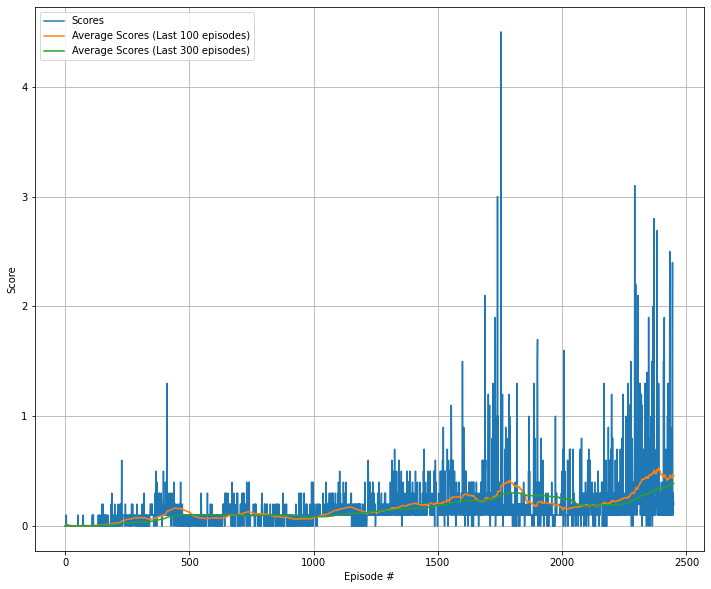

Episode 2450	Average Score: 0.4539	Max Score: 2.8000
Episode 2451	Average Score: 0.4479	Max Score: 2.8000
Episode 2452	Average Score: 0.4409	Max Score: 2.8000
Episode 2453	Average Score: 0.4369	Max Score: 2.8000
Episode 2454	Average Score: 0.4379	Max Score: 2.8000
Episode 2455	Average Score: 0.4439	Max Score: 2.8000
Episode 2456	Average Score: 0.4429	Max Score: 2.8000
Episode 2457	Average Score: 0.4429	Max Score: 2.8000
Episode 2458	Average Score: 0.4419	Max Score: 2.8000
Episode 2459	Average Score: 0.4579	Max Score: 2.8000
Episode 2460	Average Score: 0.4999	Max Score: 4.3000
Episode 2461	Average Score: 0.4999	Max Score: 4.3000
Episode 2462	Average Score: 0.5129	Max Score: 4.3000
Episode 2463	Average Score: 0.5139	Max Score: 4.3000
Episode 2464	Average Score: 0.5659	Max Score: 5.2000
Episode 2465	Average Score: 0.5649	Max Score: 5.2000
Episode 2466	Average Score: 0.5759	Max Score: 5.2000
Episode 2467	Average Score: 0.5569	Max Score: 5.2000
Episode 2468	Average Score: 0.5699	Max Score: 

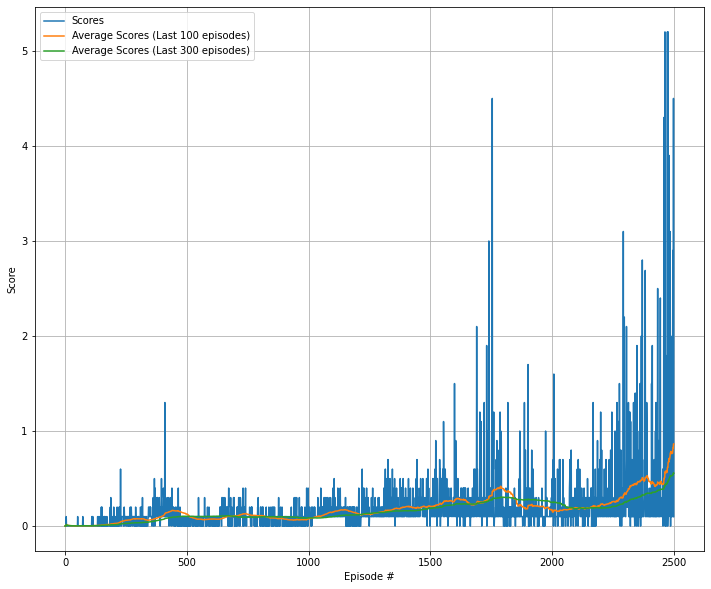

Episode 2500	Average Score: 0.8650	Max Score: 5.2000
Episode 2501	Average Score: 0.8660	Max Score: 5.2000
Episode 2502	Average Score: 0.8720	Max Score: 5.2000
Episode 2503	Average Score: 0.8710	Max Score: 5.2000
Episode 2504	Average Score: 0.8700	Max Score: 5.2000
Episode 2505	Average Score: 0.9190	Max Score: 5.2000
Episode 2506	Average Score: 0.9440	Max Score: 5.2000
Episode 2507	Average Score: 0.9430	Max Score: 5.2000
Episode 2508	Average Score: 0.9420	Max Score: 5.2000
Episode 2509	Average Score: 0.9640	Max Score: 5.2000
Episode 2510	Average Score: 0.9880	Max Score: 5.2000
Episode 2511	Average Score: 1.0280	Max Score: 5.2000
Episode 2512	Average Score: 1.0120	Max Score: 5.2000
Episode 2513	Average Score: 1.0270	Max Score: 5.2000
Episode 2514	Average Score: 1.0280	Max Score: 5.2000
Episode 2515	Average Score: 1.0330	Max Score: 5.2000
Episode 2516	Average Score: 1.0310	Max Score: 5.2000
Episode 2517	Average Score: 1.0520	Max Score: 5.2000
Episode 2518	Average Score: 1.0570	Max Score: 

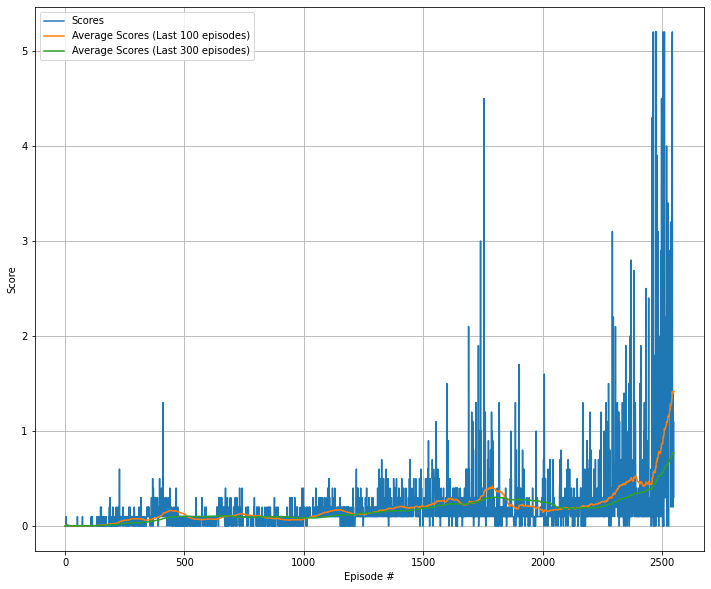

Episode 2550	Average Score: 1.4150	Max Score: 5.2000
Episode 2551	Average Score: 1.4180	Max Score: 5.2000
Episode 2552	Average Score: 1.4260	Max Score: 5.2000
Episode 2553	Average Score: 1.4410	Max Score: 5.2000
Episode 2554	Average Score: 1.4400	Max Score: 5.2000
Episode 2555	Average Score: 1.4360	Max Score: 5.2000
Episode 2556	Average Score: 1.4400	Max Score: 5.2000
Episode 2557	Average Score: 1.4400	Max Score: 5.2000
Episode 2558	Average Score: 1.4470	Max Score: 5.2000
Episode 2559	Average Score: 1.4260	Max Score: 5.2000
Episode 2560	Average Score: 1.3980	Max Score: 5.2000
Episode 2561	Average Score: 1.4120	Max Score: 5.2000
Episode 2562	Average Score: 1.3860	Max Score: 5.2000
Episode 2563	Average Score: 1.4030	Max Score: 5.2000
Episode 2564	Average Score: 1.3510	Max Score: 5.2000
Episode 2565	Average Score: 1.3720	Max Score: 5.2000
Episode 2566	Average Score: 1.3550	Max Score: 5.2000
Episode 2567	Average Score: 1.3850	Max Score: 5.2000
Episode 2568	Average Score: 1.3780	Max Score: 

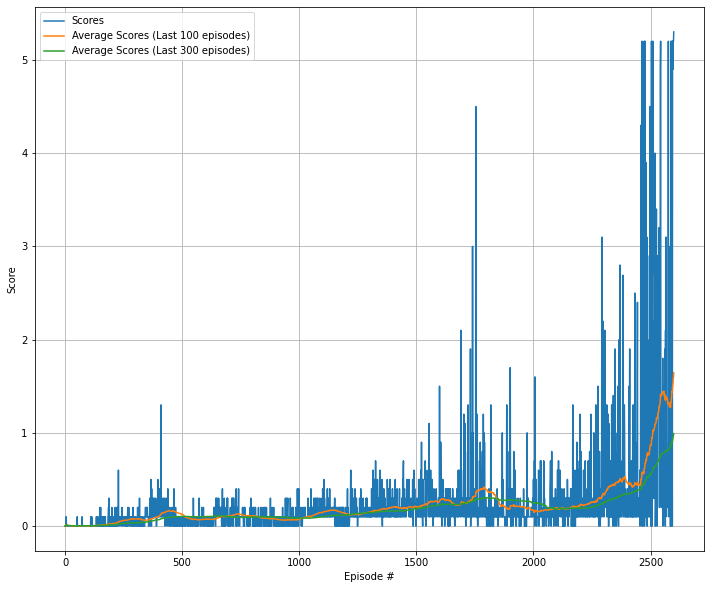

Episode 2600	Average Score: 1.6450	Max Score: 5.3000
Episode 2601	Average Score: 1.6700	Max Score: 5.3000
Episode 2602	Average Score: 1.6740	Max Score: 5.3000
Episode 2603	Average Score: 1.7240	Max Score: 5.3000
Episode 2604	Average Score: 1.7410	Max Score: 5.3000
Episode 2605	Average Score: 1.7410	Max Score: 5.3000
Episode 2606	Average Score: 1.7430	Max Score: 5.3000
Episode 2607	Average Score: 1.7830	Max Score: 5.3000
Episode 2608	Average Score: 1.7870	Max Score: 5.3000
Episode 2609	Average Score: 1.7830	Max Score: 5.3000
Episode 2610	Average Score: 1.8080	Max Score: 5.3000
Episode 2611	Average Score: 1.8080	Max Score: 5.3000
Episode 2612	Average Score: 1.8580	Max Score: 5.3000
Episode 2613	Average Score: 1.8940	Max Score: 5.3000
Episode 2614	Average Score: 1.9440	Max Score: 5.3000
Episode 2615	Average Score: 1.9490	Max Score: 5.3000
Episode 2616	Average Score: 1.9980	Max Score: 5.3000
Episode 2617	Average Score: 2.0100	Max Score: 5.3000

Environment solved (and improved) in 2517 epi

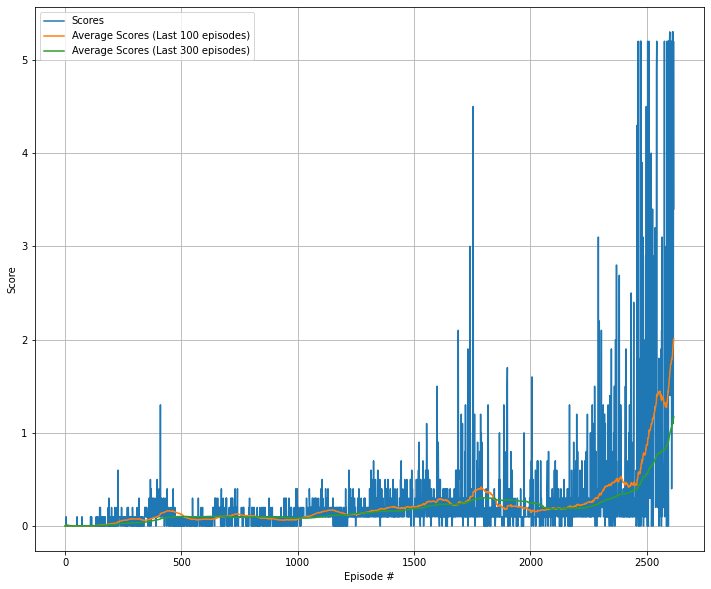

In [8]:
scores, scores_mean = ddpg()

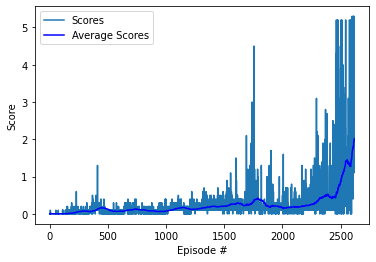

In [9]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores, label='Scores')
plt.plot(np.arange(len(scores)), scores_mean, c='b', label='Average Scores')
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.legend(loc='upper left');
plt.show()

# Watch Agent

In [10]:
scores_deque = deque(maxlen=100)
agent_scores = []
scores_window = []
scores_moving_avg = []
valid = True
    
    
for i_episode in range(1, 15):
    env_info = env.reset(train_mode=False)[brain_name] # reset the environment
    states = np.reshape(env_info.vector_observations, (1,num_agents*state_size)) # flatten states  
        
    for agent in agents:
        agent.reset()
            
    scores = np.zeros(num_agents) 
        
    for t in range(max_t):
        actions = np.reshape([agent.act(states, add_noise=False) for agent in agents], (1, num_agents*action_size))
        env_info = env.step(actions)[brain_name]
            
        next_states = np.reshape(env_info.vector_observations, (1, num_agents*state_size)) 
        rewards = env_info.rewards                   
        dones = env_info.local_done 
 
 
                    
        states = next_states
        scores += np.max(rewards)
        if np.any(dones):
            break 
        
        
score = np.max(scores)
scores_deque.append(score)
scores_window.append(score)
scores_moving_avg.append(np.mean(scores_window))
